# Домашнее задание №2 - Линейные модели. Градиентный спуск

В этом домашнем задании мы с вами научимся обучать линейные модели регрессии и классификации при помощи очень мощного, но в то же время довольно понятного алгоритма, который называется **градиетный спуск**. Помимо линейных моделей он используется и для обучения самых сложных нейронных сетей! Также мы потренируемся применять готовые реализации линейных моделей для задач регрессии и бинарной классификации.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import fetch_california_housing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (StandardScaler,
                                   OneHotEncoder)
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_absolute_error,
                             mean_squared_error)
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

#### Маленькое теоретическое отступление

Основное свойство антиградиента (-1 * градиент) &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента, пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (коэффициентов линейной модели) ((например, нулевой или сгенерированный из некоторого, случайного распределения)). Тогда обычный градиентный спуск состоит в повторении следующих шагов до сходимости:


$$
    w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}),
$$

где $\nabla_{w} Q(w_{k})$ &ndash; градиент функции потерь в точке $w_k$, а $\eta$ &ndash; скорость обучения (learning rate).

Градиентный спуск обычно останавливают, когда прошло заданное максимальное количество итераций или когда графиент близок к нулю (т.е. наши параметры практически не меняются). Для реализации второго варианта считают норму градиента (по сути длину вектора). Это можно сделать несколькими способами:

$$
l1_{norm} = \sum{|w_i|}
$$

$$
l2_{norm} = \sum{(w_i)^{2}}
$$

Попробуем разобраться на простом примере. Рассмотрим функцию от двух переменных:
$f(x, y) = \sin^2 x + \sin^2 y$

In [3]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

Обратите внимание, что $x$ - numpy-array вектор длины 2.

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $w_1$ и $w_2$ такие, что при них значение $f(w_1, w_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

### Задание 1. Градиентный спуск для функции $f$ (1 балл)

Реализуйте функцию, которая будет осуществлять градиентный спуск для функции $f$:

*Примечание:* Вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

In [4]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
    
    
    return list(map(lambda x: 2 * np.sin(x) * np.cos(x), w))

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение

In [5]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [6]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
    
        curr_w -= lr * np.sum(curr_w)

    return np.vstack(history)

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $w_1, w_2, f(w_1, w_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму (Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_w_1, cur\_w_2, f(cur\_w_1, cur\_w_2)$ в `steps` в процессе спуска).

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точек минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [7]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.add_subplot(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker="*", markersize=20, zorder=3, 
            markerfacecolor="y", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=60)
    plt.show()
    
    return steps

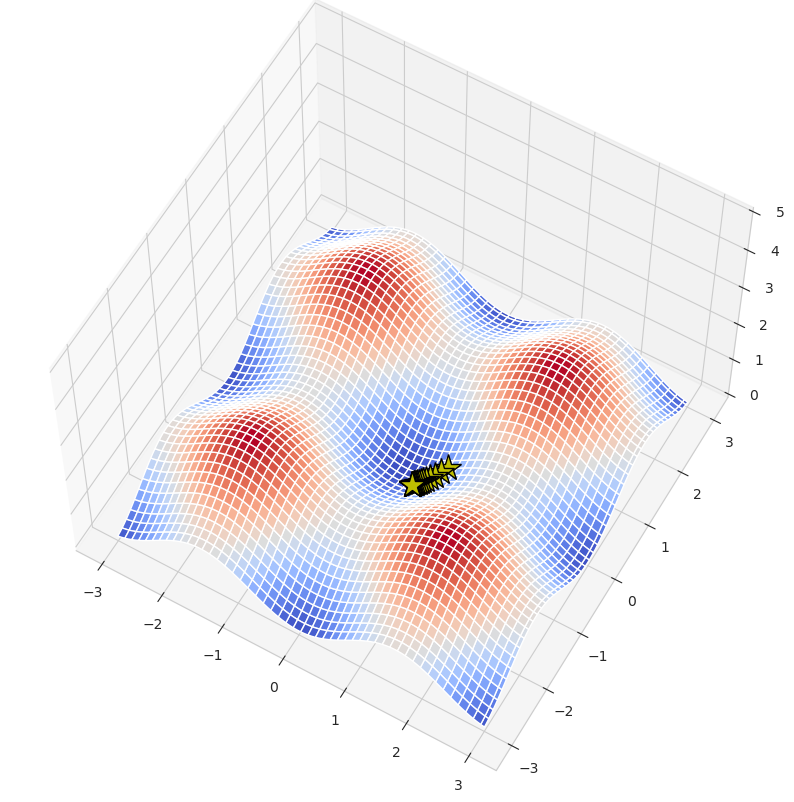

In [8]:
steps = gradient_desc_vis(f, grad_f)

Посмотрим на зависимость значения функции от шага градиентного спуска.

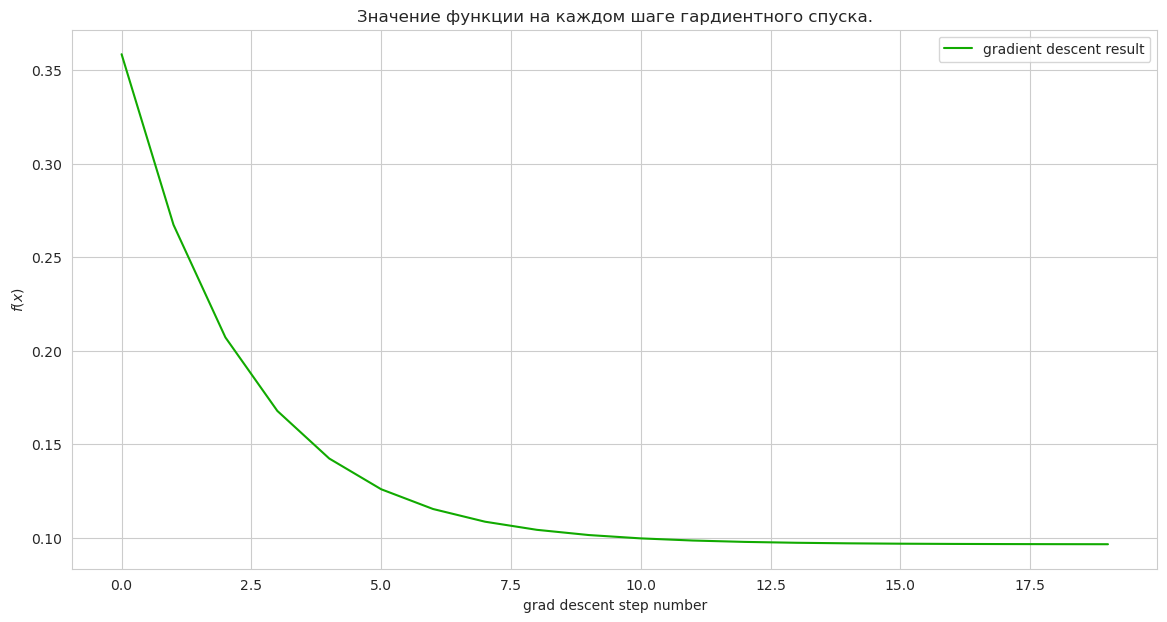

In [9]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге гардиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, "#1a0", label="gradient descent result")
plt.legend();

### Задание 2. Реализация линейной регресии (суммарно 9 баллов)

Так как мы будем использовать градиентный спуск для обучения модели, важной часть является реализация функции потерь и функции для расчета ее градиента. Перем началом стоит напомнить, как считать градиент MSE. Вывод этой формулы можно найти  [здесь](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
    MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
    \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

Здесь имеется в виду именно матричное умножение.

#### Задание 2.1. MSE и ее градиент (2 балла)

In [10]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    mse_value = np.sum(np.square(y_true - y_pred)) / y_true.shape[0]
    return mse_value


def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    return (2 / y_true.shape[0]) * (X.T @ (y_pred - y_true)) 
    

class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [11]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X)
        grad_i_norm = self._calculate_grad_norm(grad_i)
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1":
            return np.abs(grad_i).sum()
        elif self.grad_norm == "l2":
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

В данном задании нужно будет реализовать линейную регрессию и обучить ее при помощи градиентного спуска. Для этого нужно будет заполнять пропуски кода в соответствующих классах. Для начала мы реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий. Не переживайте, этот класс уже реализован, вам достостаточно просто разобраться с кодом.

In [12]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)
            
            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

#### Задание 2.2. Предсказания линейной регрессии (3 балла)

Реализуйте метод `predict` у класса `CustomLinearRegression`, не забудьте про свободный член!

In [13]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        y_pred = X_test @ self.W   
        return y_pred
    
    
    def __repr__(self):
        return "My custom linear regression"

##### Проверим нашу реализацию на простом примере

In [14]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

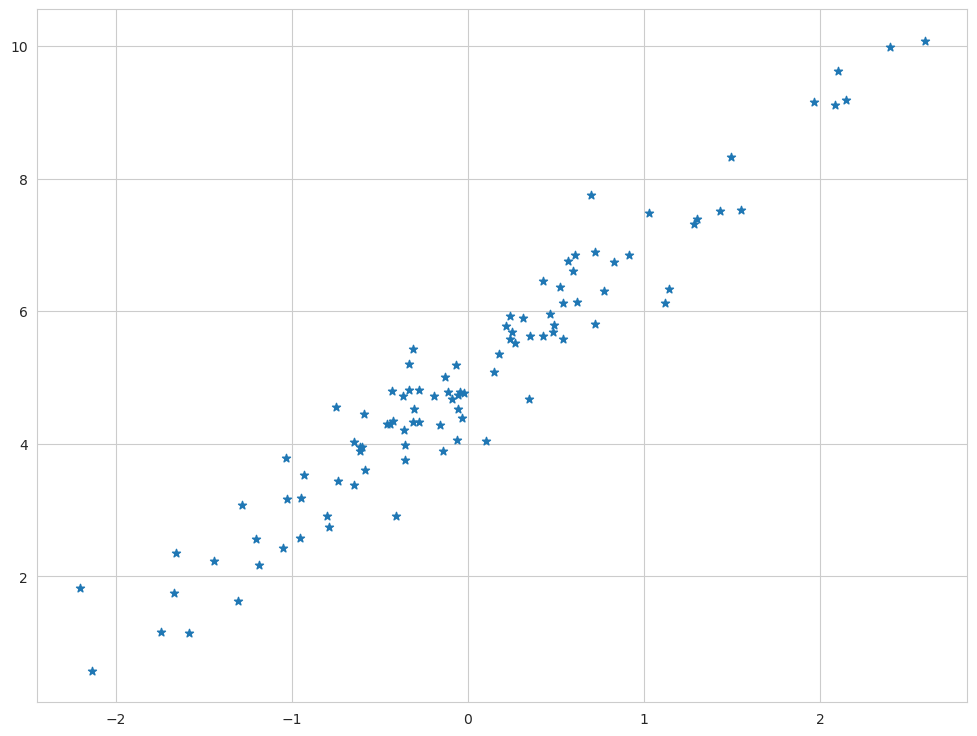

In [15]:
plt.scatter(X, y, marker='*');

In [16]:
custom_lin_reg = CustomLinearRegression()

In [17]:
custom_lin_reg.fit(X, y)

My custom linear regression

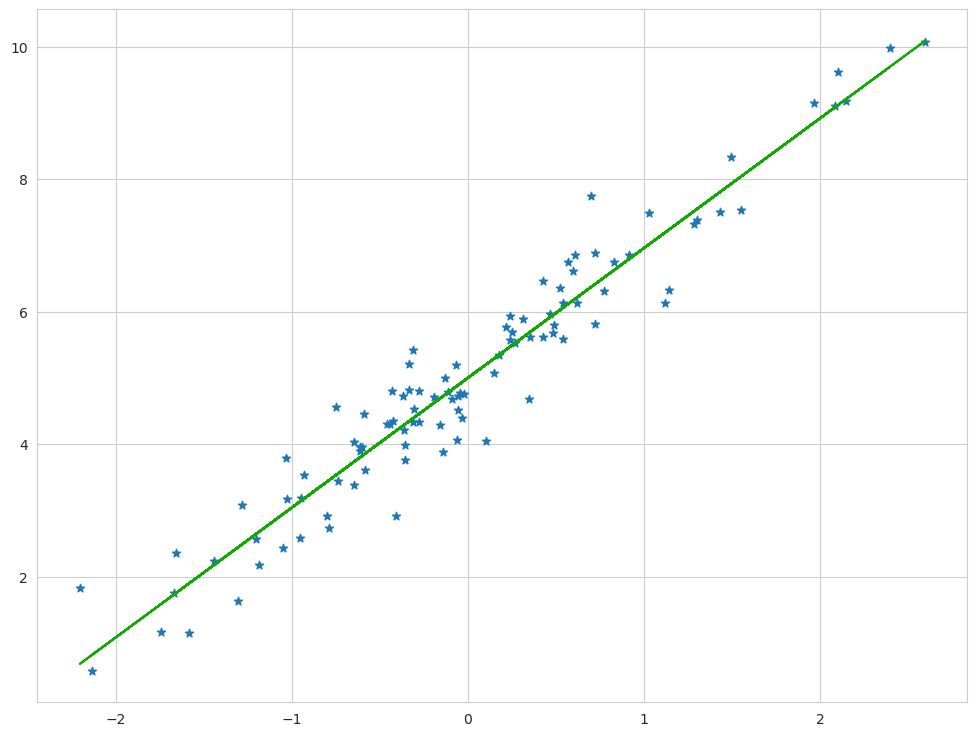

In [18]:
plt.scatter(X, y, marker='*')
plt.plot(X, custom_lin_reg.predict(X), "#1a0");

#### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

Поработаем с данными о ценах на дома в Калифорнии. Постройте модель линейной регресии при помощи `LinearRegression` из `sklearn`. Не забудьте разделить данные на тренировочную и тестовую части, а также правильно предобработать признаки. В конце воспользуйтесь какими-то изученными метриками регресии и сделайте выводы о качестве полученной модели, а также о том, какие признаки наиболее важны с точки зрения полученной модели.

In [19]:
data = fetch_california_housing()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

Ваш ход:

### 1. Let's perform EDA

1) Let's obtain overall description for X and y.

In [20]:
X = pd.DataFrame(data=X, columns=feature_names)
y = pd.Series(y)
X.head()

MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25

In [21]:
# X and y sizes
X.shape, y.shape

((20640, 8), (20640,))

In [22]:
# description for X
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
dtypes: float64(8)
memory usage: 1.3 MB


In [23]:
# description for y
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 20640 entries, 0 to 20639
Series name: None
Non-Null Count  Dtype  
--------------  -----  
20640 non-null  float64
dtypes: float64(1)
memory usage: 161.4 KB


We have eight features and 20640 observations.

2) Let's take a look on mean and std for all features and target

In [24]:
X.describe()

MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude  
count  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704  
std       10.386050      2.135952      2.003532  
min        0.692308     32.540000   -124.350000  
25%        2.429741     33.930000   -121.800000  
50%        2.818116     34.260000   -118.490000  
75%        3.282261     37.710000   -118.010000  
max     1243.333333     41.950000   -114.310000

Obviously, features should be standardized due to a big difference in their mean and std.

In [25]:
y.describe()

count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
dtype: float64

3) Let's visualize distribution for both features and target

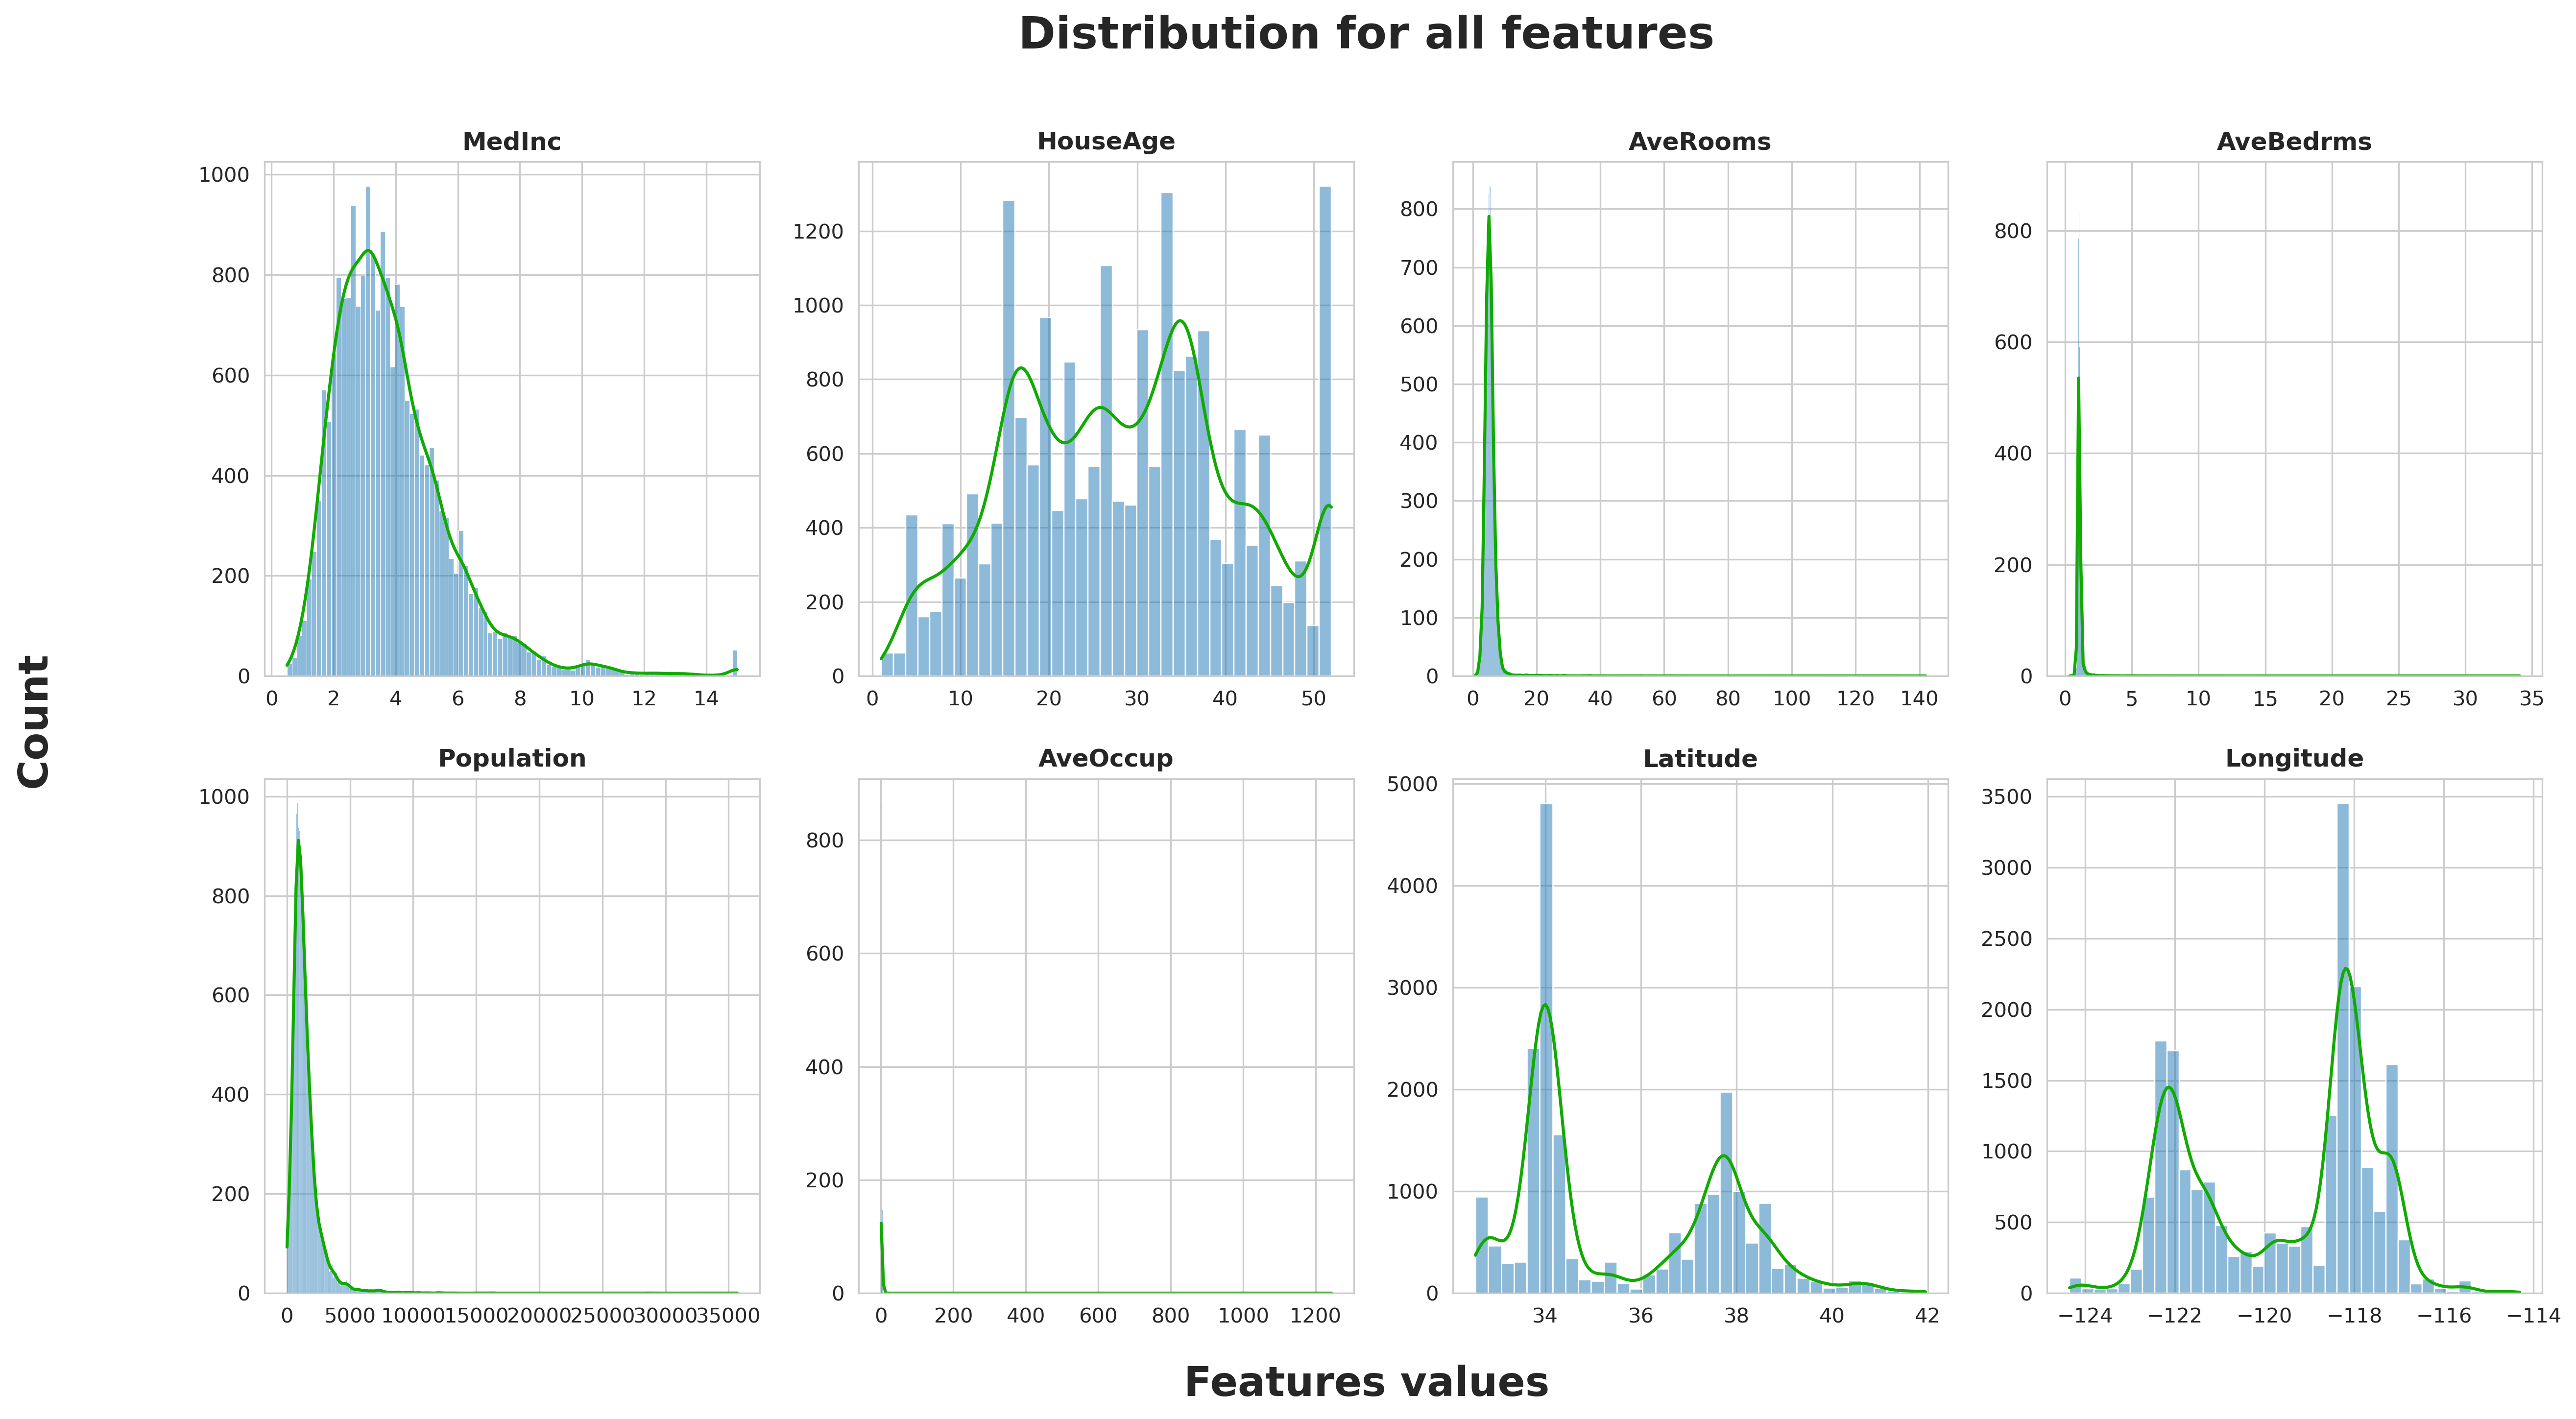

In [26]:
## histplot for all features
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(20, 10), dpi=300)

for i, ax in zip(range(8), axes.flat):
    sns.histplot(X.iloc[:, i], kde=True, ax=ax)
    ax.set(xlabel='', ylabel='')
    ax.set_title(X.columns[i], fontsize=12, fontweight='bold')
    ax.lines[0].set_color("#1a0")
    
fig.suptitle("Distribution for all features", fontsize=22, fontweight="bold")
fig.text(0.5, 0.04, 'Features values', ha='center', 
         fontsize=20, fontweight='bold')
fig.text(0.04, 0.5, 'Count', va='center', 
         rotation='vertical', fontsize=20, fontweight='bold')

plt.show();

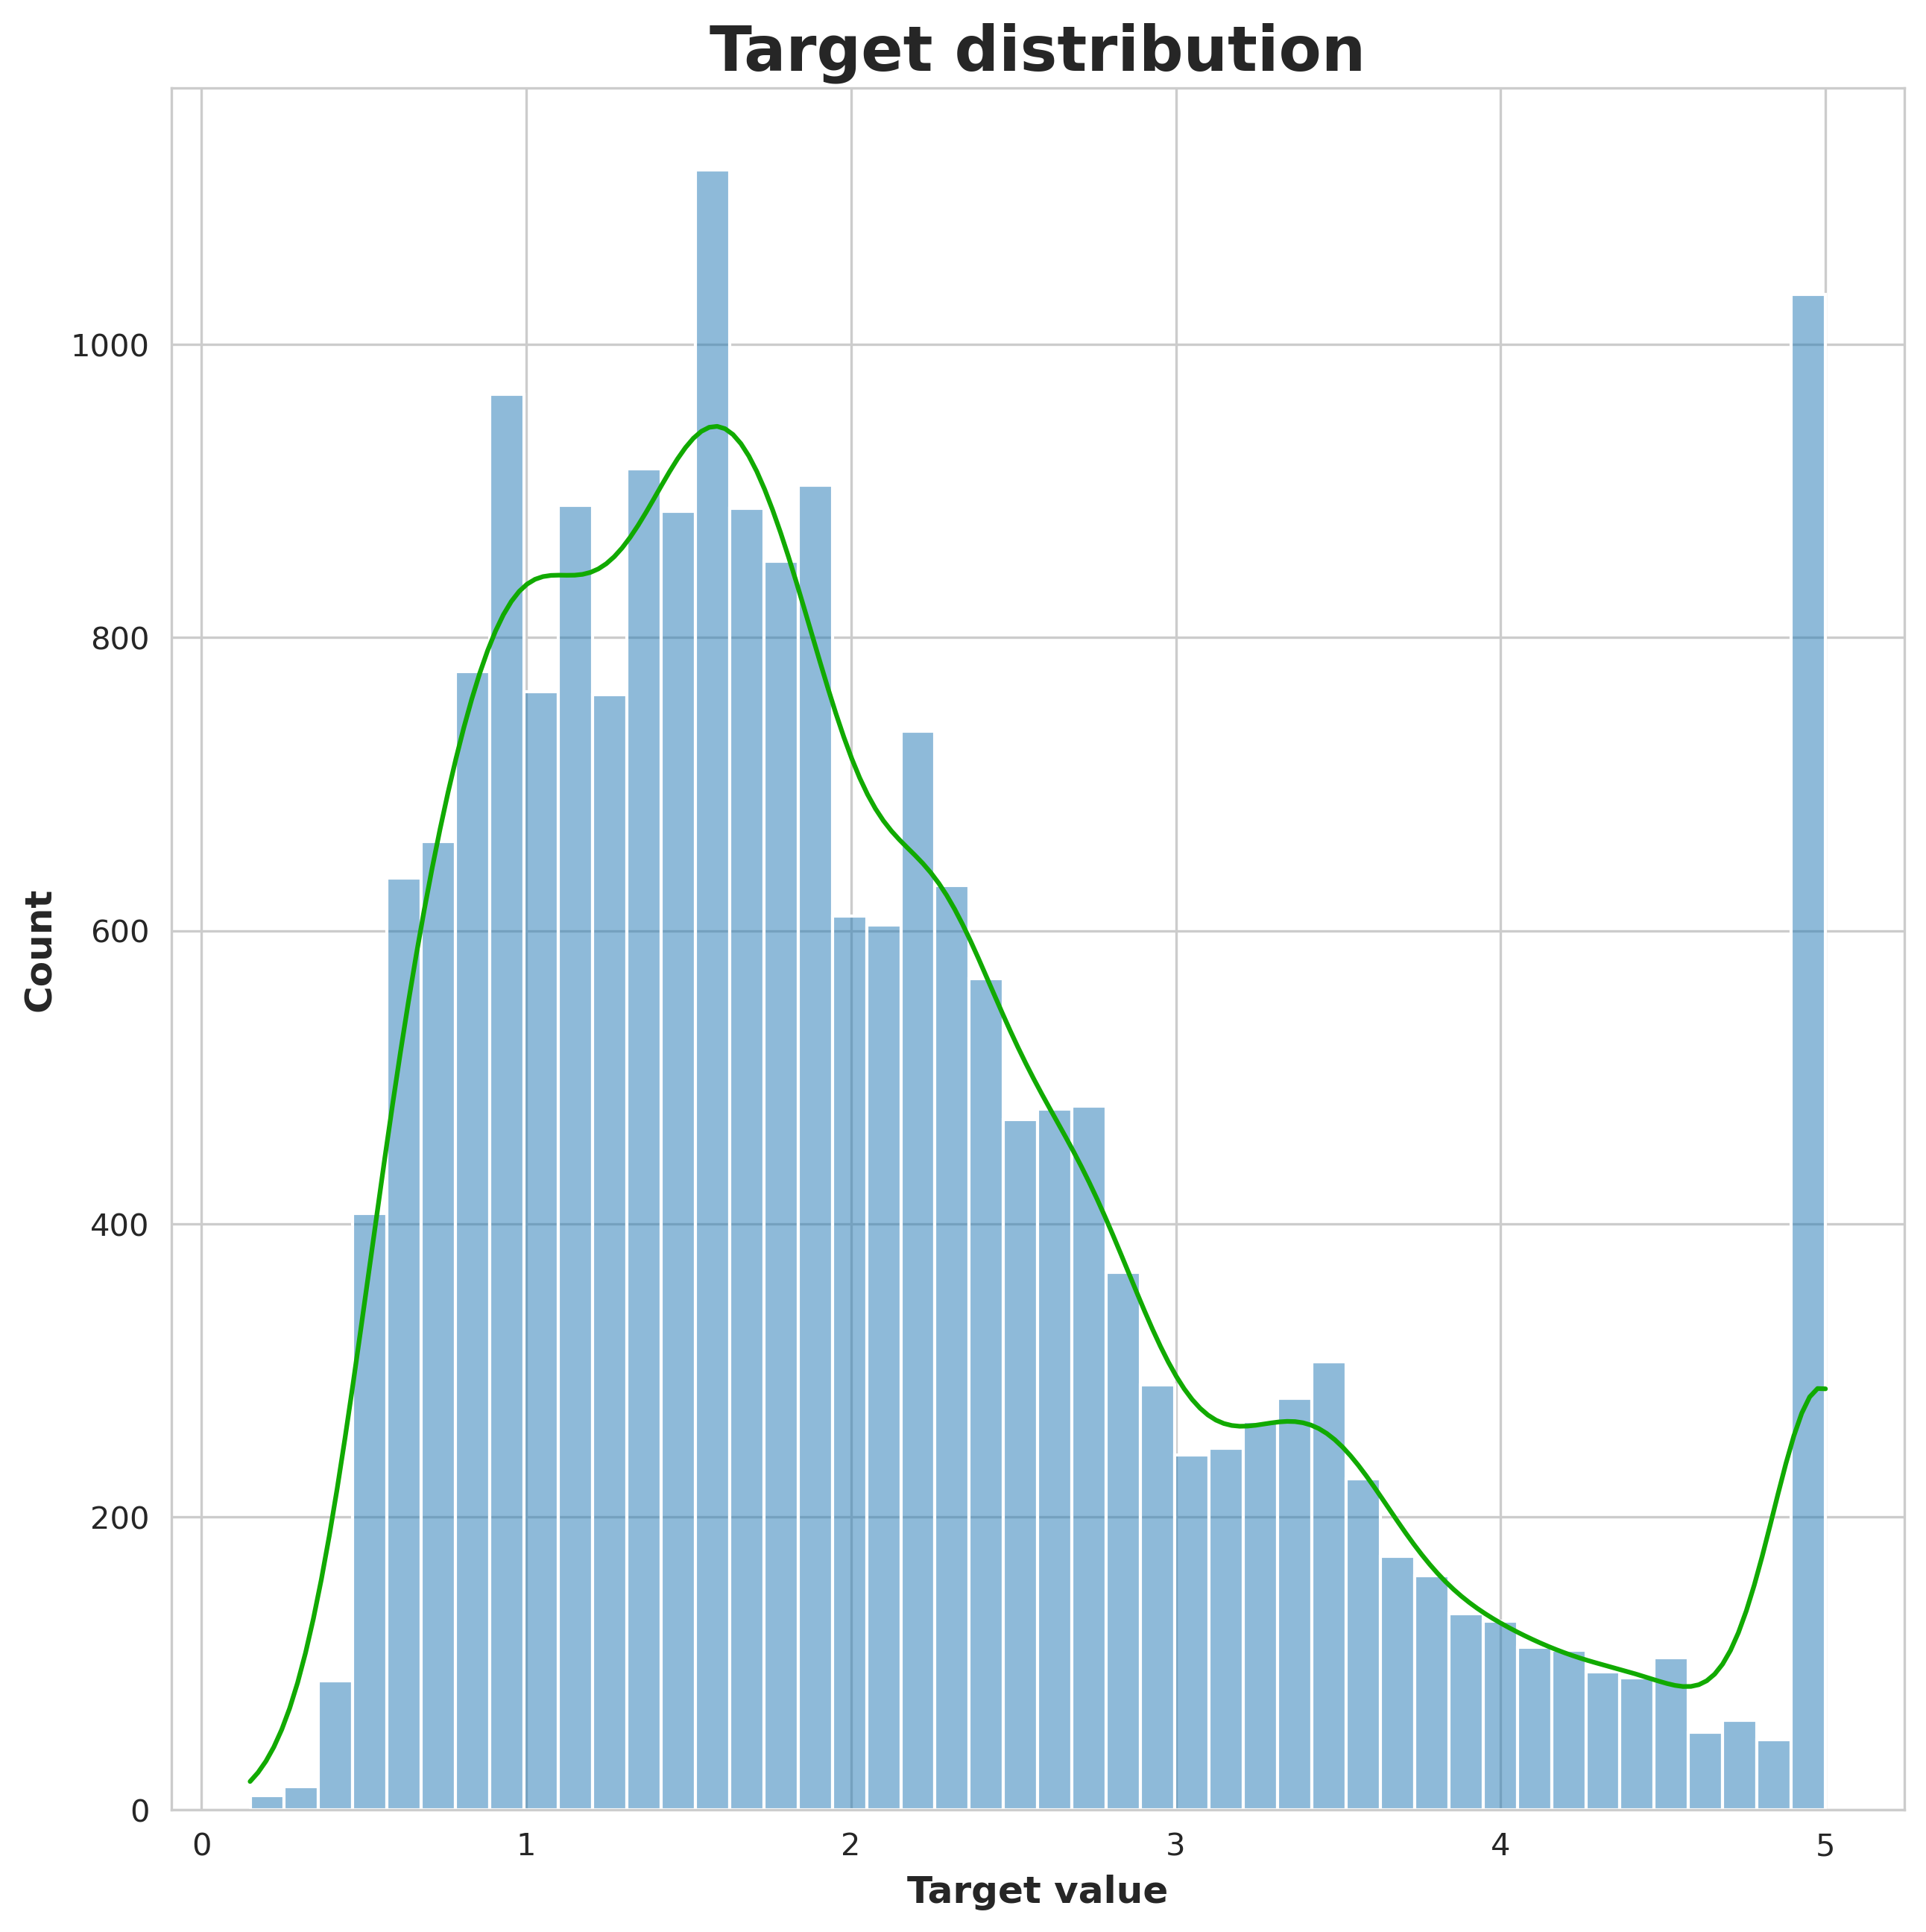

In [27]:
# histplot for target
fig, ax = plt.subplots(1, figsize=(10, 10), dpi=300)
sns.histplot(y, kde=True, ax=ax)
ax.set_xlabel('Target value', fontsize=12, fontweight="bold")
ax.set_ylabel('Count', fontsize=12, fontweight="bold")
ax.set_title("Target distribution", fontsize=20, fontweight='bold')
ax.lines[0].set_color("#1a0")

Distributions of features and targets are far from normal.

4. Let's check whether our features correlates with each other and target

In [28]:
full_df = X.assign(y=y)

In [29]:
corr = full_df.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(3))

/tmp/ipykernel_1755/721199717.py:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  (corr


The *Latitude* and *Longitude* have atrong positive correlation, while the correlation between *AveRooms* and *AveBedrms* is near to -1 (strong negative correlation). 

As we can see, the most correlated feature with target is *MedInc*.

Firstly, I decided to create linear model with all features, check iys quality and then try to improve model.

### 2. Linear model with all features

Now we are going to split data on train and test, standardize variables and create linear model using Pipeline.

In [30]:
# spliting train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=SEED)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((15480, 8), (15480,), (5160, 8), (5160,))

In [31]:
# fitting model with Pipeline and making prediction
pipeline_reg = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('linear_reg', LinearRegression())])

pipeline_reg.fit(X_train, y_train)
y_pred = pipeline_reg.predict(X_test)

In [32]:
print("Metrics for linear regression on all features:")
print(f'r2 score: {r2_score(y_test, y_pred)}', 
      f'MAE score: {mean_absolute_error(y_test, y_pred)}', 
      f'MSE score: {mean_squared_error(y_test, y_pred)}', sep='\n')

Metrics for linear regression on all features:
r2 score: 0.6021374561427344
MAE score: 0.533877778997567
MSE score: 0.5351866874069421


Now I want to look at VIF for train and test data. Before VIF calculation, I standardize features out from Pipeline. 

In [33]:
# standardizing features
scaler = StandardScaler()
X_train_stand = scaler.fit_transform(X_train)
X_test_stand = scaler.transform(X_test)

In [34]:
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["features"] = feature_names
    vif["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    return vif

# VIF for train for all features
vif = calc_vif(X_train_stand)
vif

features       VIF
0      MedInc  2.583347
1    HouseAge  1.239063
2    AveRooms  8.273508
3   AveBedrms  6.799707
4  Population  1.137074
5    AveOccup  1.010199
6    Latitude  9.430851
7   Longitude  9.040872

As we expected, two pairs of features are strongly correlated. Let's drop one from the each pair and try to improve our linear model.

### 3. Linear models without *AveRooms*, *AveBedrms*, *Attitude*, or *Longitude*

In [35]:
def one_drop_to_prop(X, y):
    vif = pd.DataFrame()
    
    for feature in ["AveRooms", "AveBedrms", "Latitude", "Longitude"]:
        X_one_droped = X.drop([feature], axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X_one_droped, 
                                                            y, test_size=0.25, 
                                                            random_state=SEED)
        pipeline_reg = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('linear_reg', LinearRegression())])

        pipeline_reg.fit(X_train, y_train)
        y_pred = pipeline_reg.predict(X_test)
        print(f' Metrics for linear model without {feature}:')
        print(f'r2 score: {r2_score(y_test, y_pred)}', 
              f'MAE score: {mean_absolute_error(y_test, y_pred)}', 
              f'MSE score: {mean_squared_error(y_test, y_pred)}', sep='\n')
        
        plt.figure(figsize=(7,5), dpi=300)
        sns.regplot(x=y_pred, y=y_test, marker='*', 
                    scatter_kws={'s': 2, 'alpha': 0.5}, 
                    line_kws={'linewidth': 0.5, 'color': '#1a0'}, fit_reg=True)
        plt.xlim(-1, 8)
        plt.ylim(-1, 8)
        plt.title(f'True target vs. Predicted scatter plot without {feature} feature', 
                  weight='bold')
        plt.xlabel('Predicted price', weight='bold')
        plt.ylabel('Real price', weight='bold');
        
        vif["features"] = feature_names
        drop_idx = feature_names.index(feature)
        scaler = StandardScaler()
        X_train_stand = scaler.fit_transform(X_train)
        vif_list = [variance_inflation_factor(X_train_stand, i) for i in range(X_train_stand.shape[1])]
        vif_list.insert(drop_idx, "------")
        vif[f'VIF_wo{feature}'] = vif_list
    return vif

 Metrics for linear model without AveRooms:
r2 score: 0.5968446714625668
MAE score: 0.5417121323439918
MSE score: 0.542306301816167
 Metrics for linear model without AveBedrms:
r2 score: 0.5915843883725613
MAE score: 0.5457063067059449
MSE score: 0.5493821965572734
 Metrics for linear model without Latitude:
r2 score: 0.5212216156178358
MAE score: 0.5786886290991238
MSE score: 0.6440310139661285
 Metrics for linear model without Longitude:
r2 score: 0.524807612788636
MAE score: 0.5787527928630577
MSE score: 0.6392072928681714


features VIF_woAveRooms VIF_woAveBedrms VIF_woLatitude VIF_woLongitude
0      MedInc       1.111608        1.324668       2.097198        2.185339
1    HouseAge       1.236277        1.238344       1.160663        1.150435
2    AveRooms         ------        1.288759       7.295395         7.56074
3   AveBedrms       1.059186          ------       6.388863        6.523529
4  Population        1.13472        1.136884       1.126323        1.131078
5    AveOccup       1.008512        1.008941       1.007145        1.007635
6    Latitude       8.315914        8.861031         ------        1.069503
7   Longitude       8.261995        8.673667       1.025278          ------

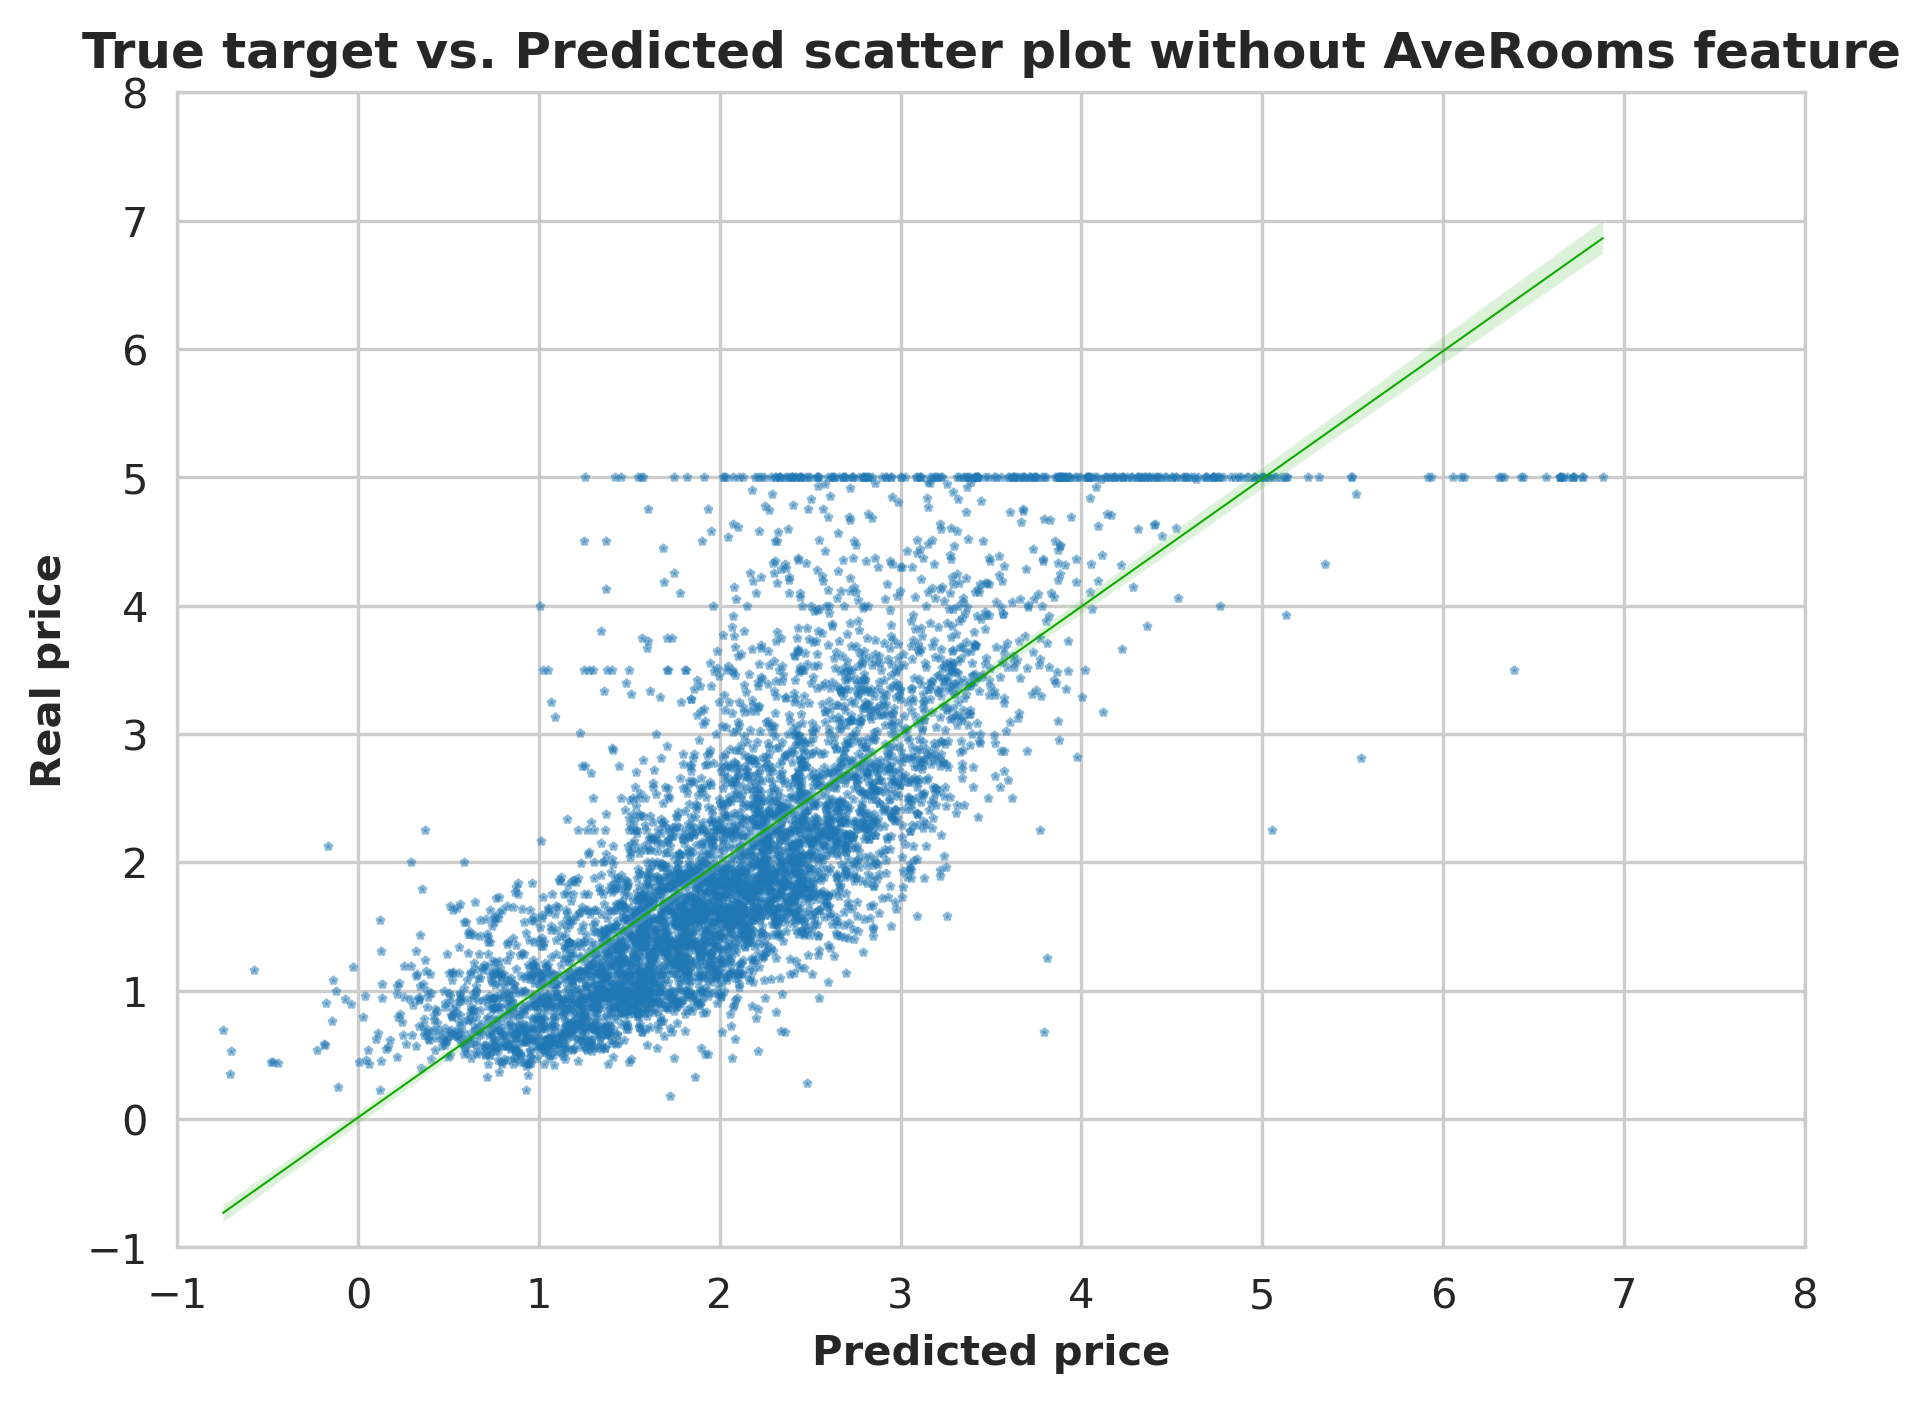

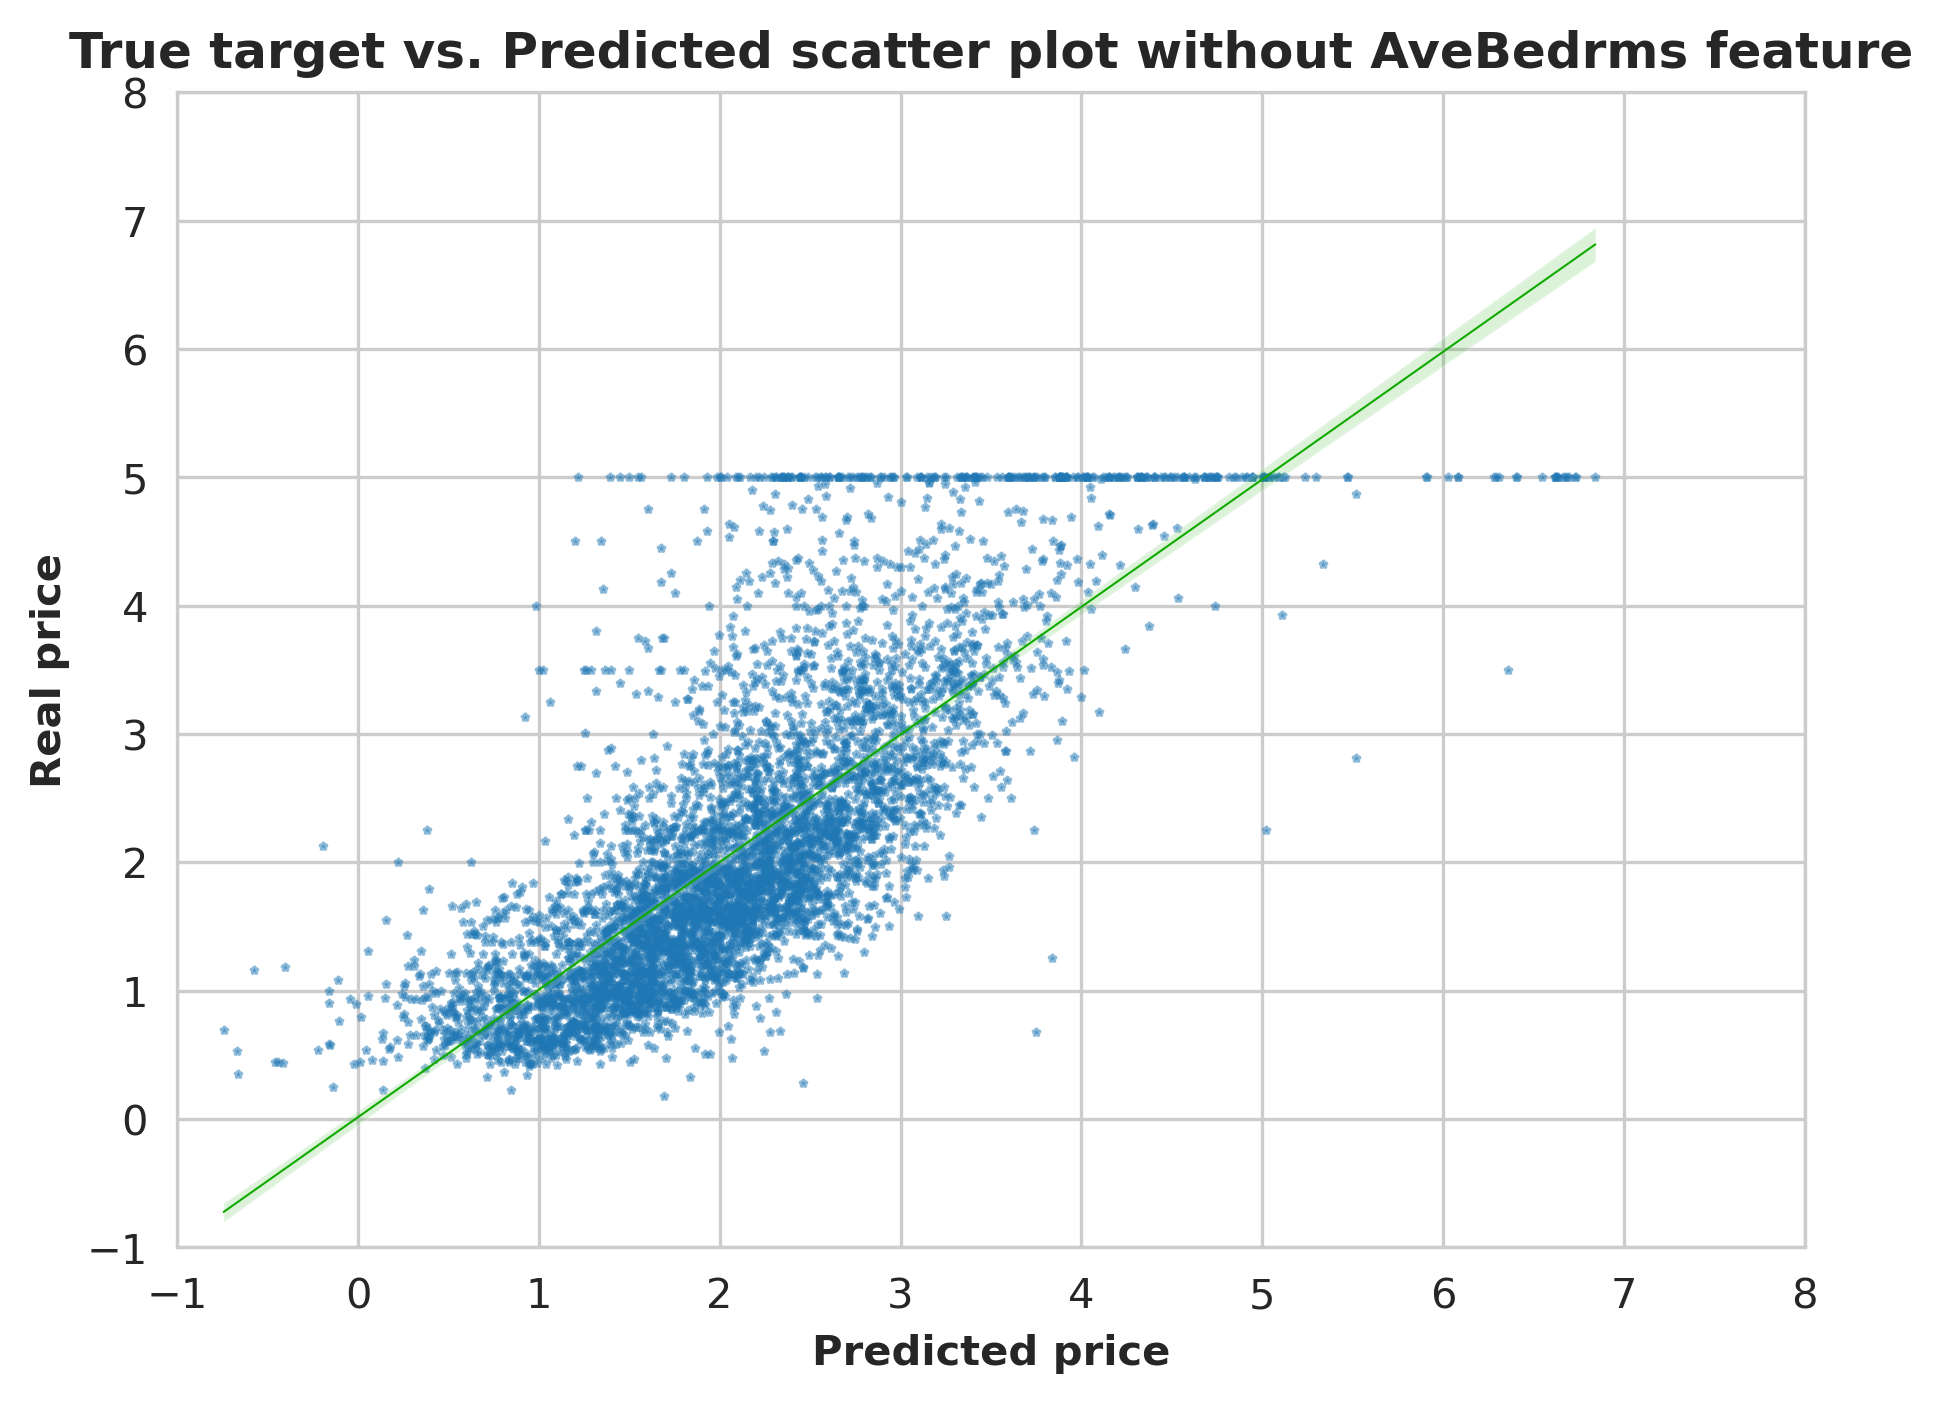

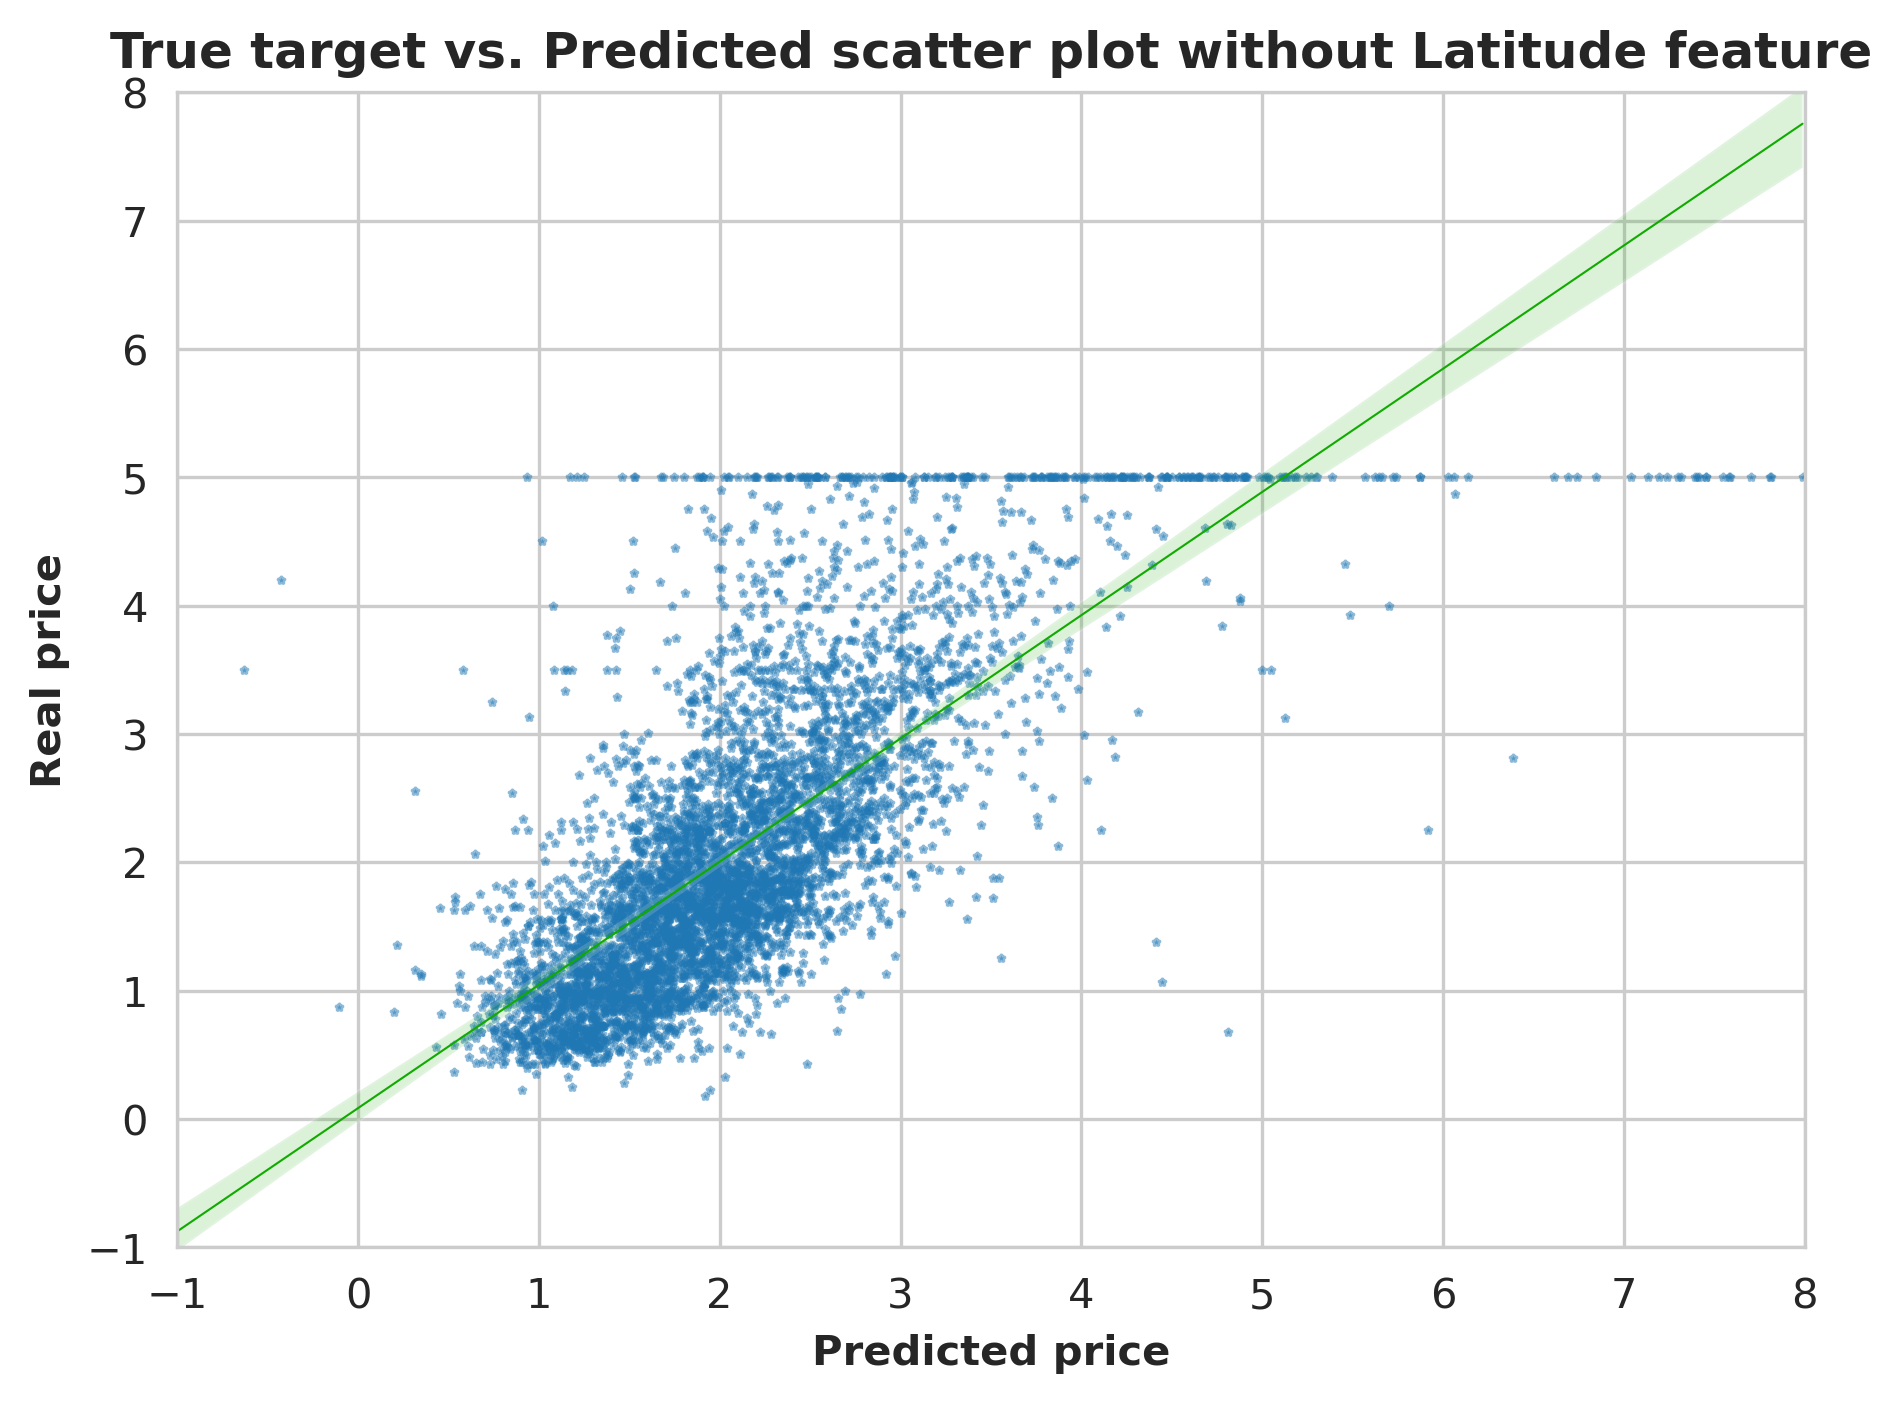

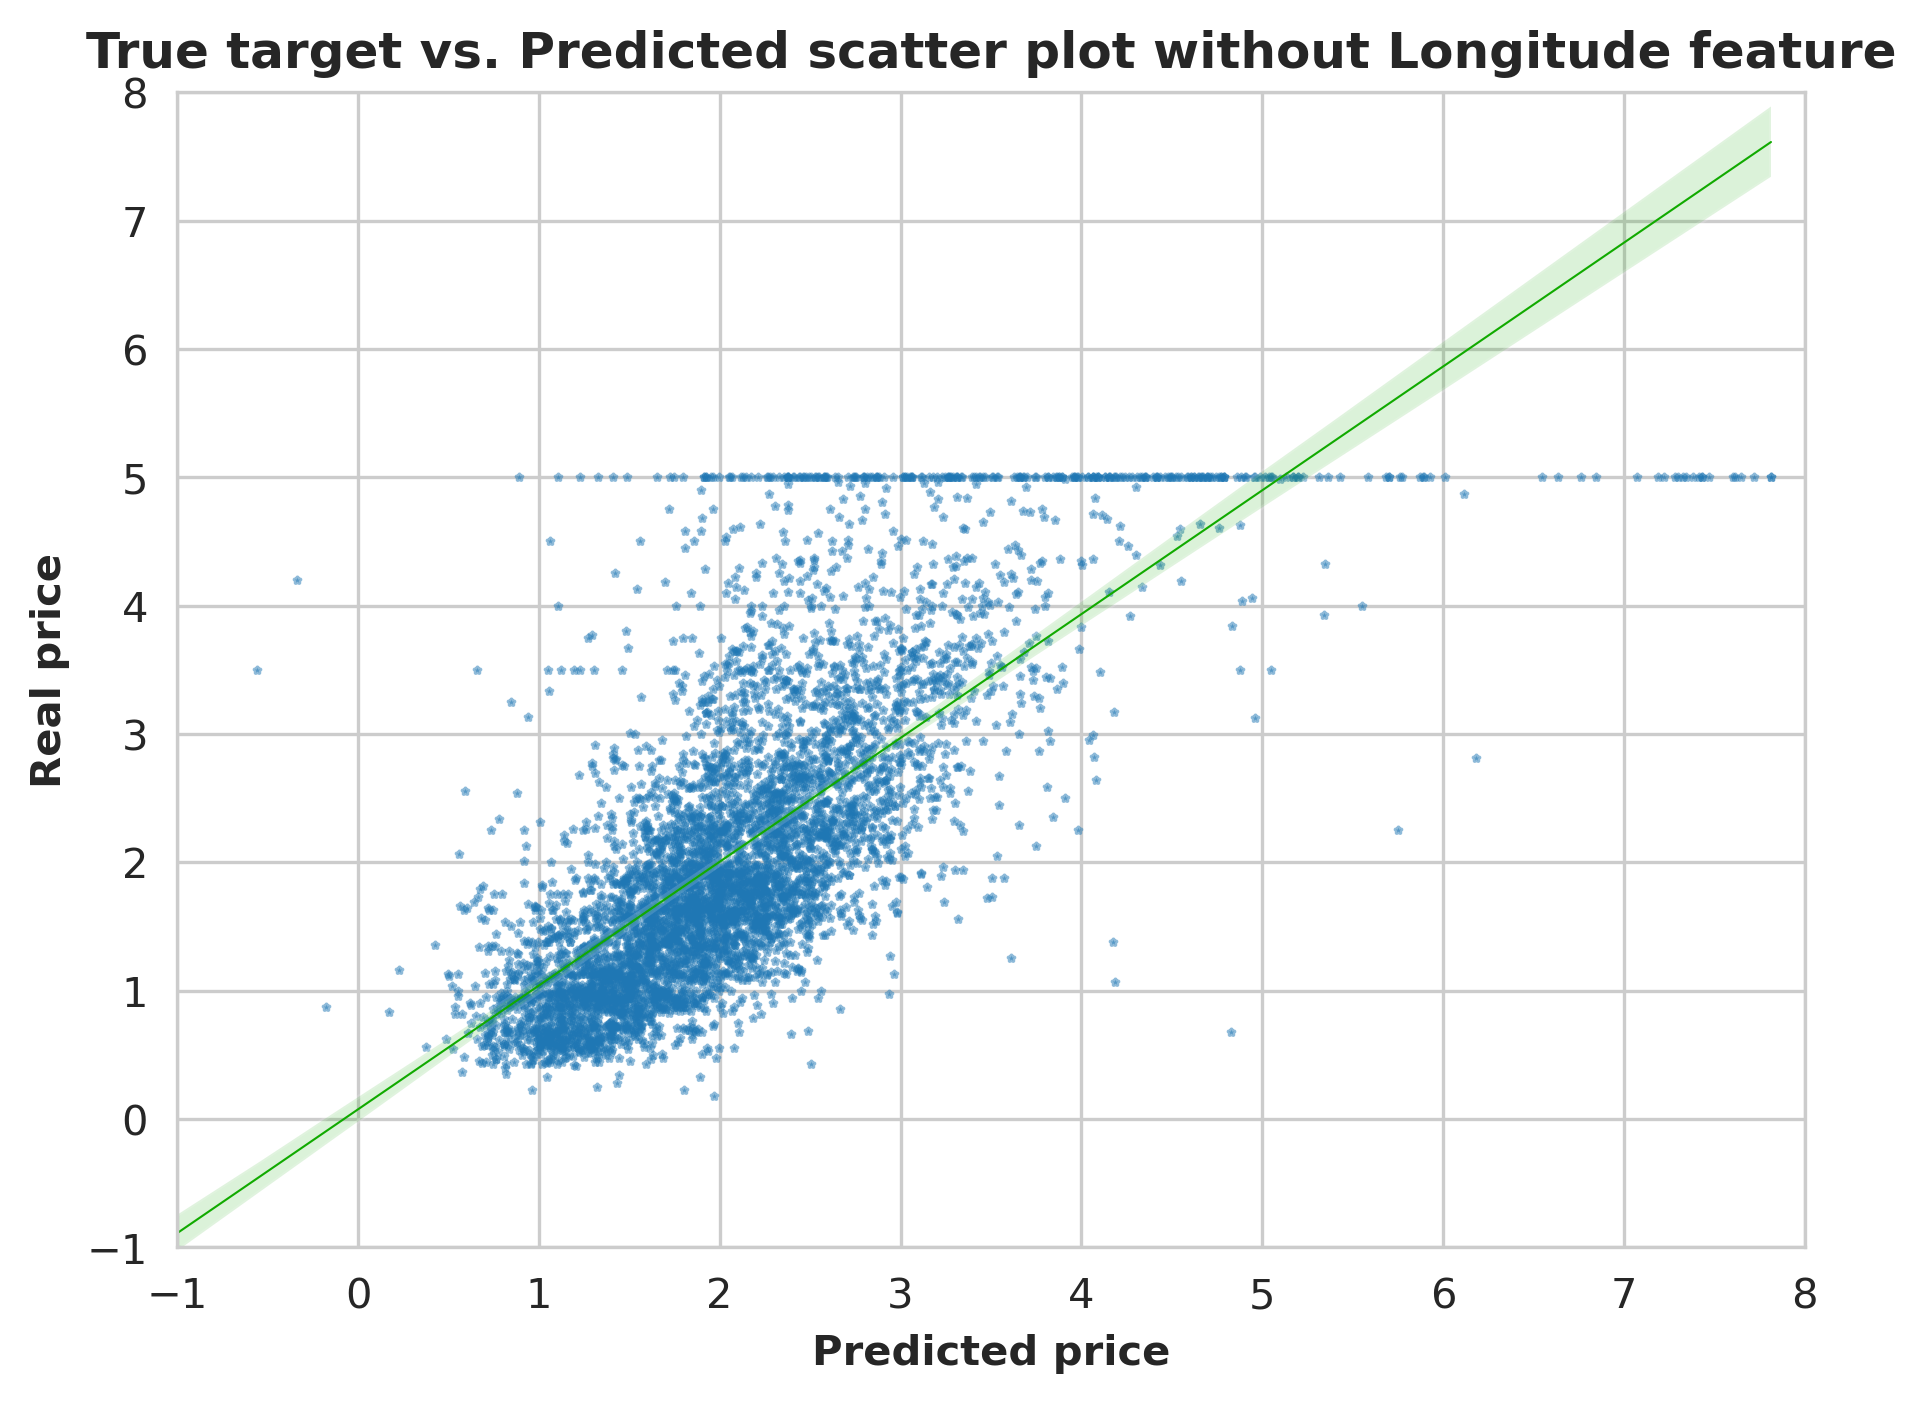

In [36]:
one_drop_to_prop(X, y)

So, for X_train when we drop one of the paired features, the VIF drastically reduces. Meanwhile, according to the quality metrics, the power of prediction is decreasing.

I decided to go further and try to remove two pairs of features: *AveBedrms* and *Longitude* (as they have higher correlation with the target insight their pairs), and *AveRooms* and *Attitude* (why not, let's check for fun).

### 4. Linear models without two feature pairs: *AveBedrms* and *Longitude*, or *AveRooms* and *Attitude*

In [37]:
def two_drops_to_prop(X, y):
    vif = pd.DataFrame()
    
    for features in [("AveBedrms", "Longitude"), ("AveRooms", "Latitude")]:
        X_two_droped = X.drop([i for i in features], axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X_two_droped, 
                                                            y, test_size=0.25, 
                                                            random_state=SEED)
        pipeline_reg = Pipeline(steps=[('scaler', StandardScaler()), 
                       ('linear_reg', LinearRegression())])

        pipeline_reg.fit(X_train, y_train)
        y_pred = pipeline_reg.predict(X_test)
        print(f' Metrics for linear model without {features}:')
        print(f'r2 score: {r2_score(y_test, y_pred)}', 
              f'MAE score: {mean_absolute_error(y_test, y_pred)}', 
              f'MSE score: {mean_squared_error(y_test, y_pred)}', sep='\n')
        
        fig, axes = plt.subplots(figsize=(7,5), dpi=300)
        sns.regplot(x=y_pred, y=y_test, marker='*', 
                    scatter_kws={'s': 2, 'alpha': 0.5}, 
                    line_kws={'linewidth': 0.5, 'color': '#1a0'}, fit_reg=True)
        plt.xlim(-1, 8)
        plt.ylim(-1, 8)
        plt.title(f'True target vs. Predicted scatter plot without {features} features', 
                  weight='bold')
        plt.xlabel('Predicted price', weight='bold')
        plt.ylabel('Real price', weight='bold');
        
        vif["features"] = feature_names
        scaler = StandardScaler()
        X_train_stand = scaler.fit_transform(X_train)
        vif_list = [variance_inflation_factor(X_train_stand, i) for i in range(X_train_stand.shape[1])]
        
        for f in features:
            drop_idx = feature_names.index(f)
            vif_list.insert(drop_idx, "------")
        vif[f'VIF_wo{features}'] = vif_list
    return vif

 Metrics for linear model without ('AveBedrms', 'Longitude'):
r2 score: 0.50679714365667
MAE score: 0.6002221980469676
MSE score: 0.6634341608209382
 Metrics for linear model without ('AveRooms', 'Latitude'):
r2 score: 0.5021738684858623
MAE score: 0.6073395086718123
MSE score: 0.669653181339047


features VIF_wo('AveBedrms', 'Longitude') VIF_wo('AveRooms', 'Latitude')
0      MedInc                         1.153888                       1.022621
1    HouseAge                         1.142581                       1.135468
2    AveRooms                         1.187536                         ------
3   AveBedrms                           ------                       1.021275
4  Population                         1.130178                        1.11829
5    AveOccup                         1.006969                       1.006592
6    Latitude                         1.038628                         ------
7   Longitude                           ------                       1.015903

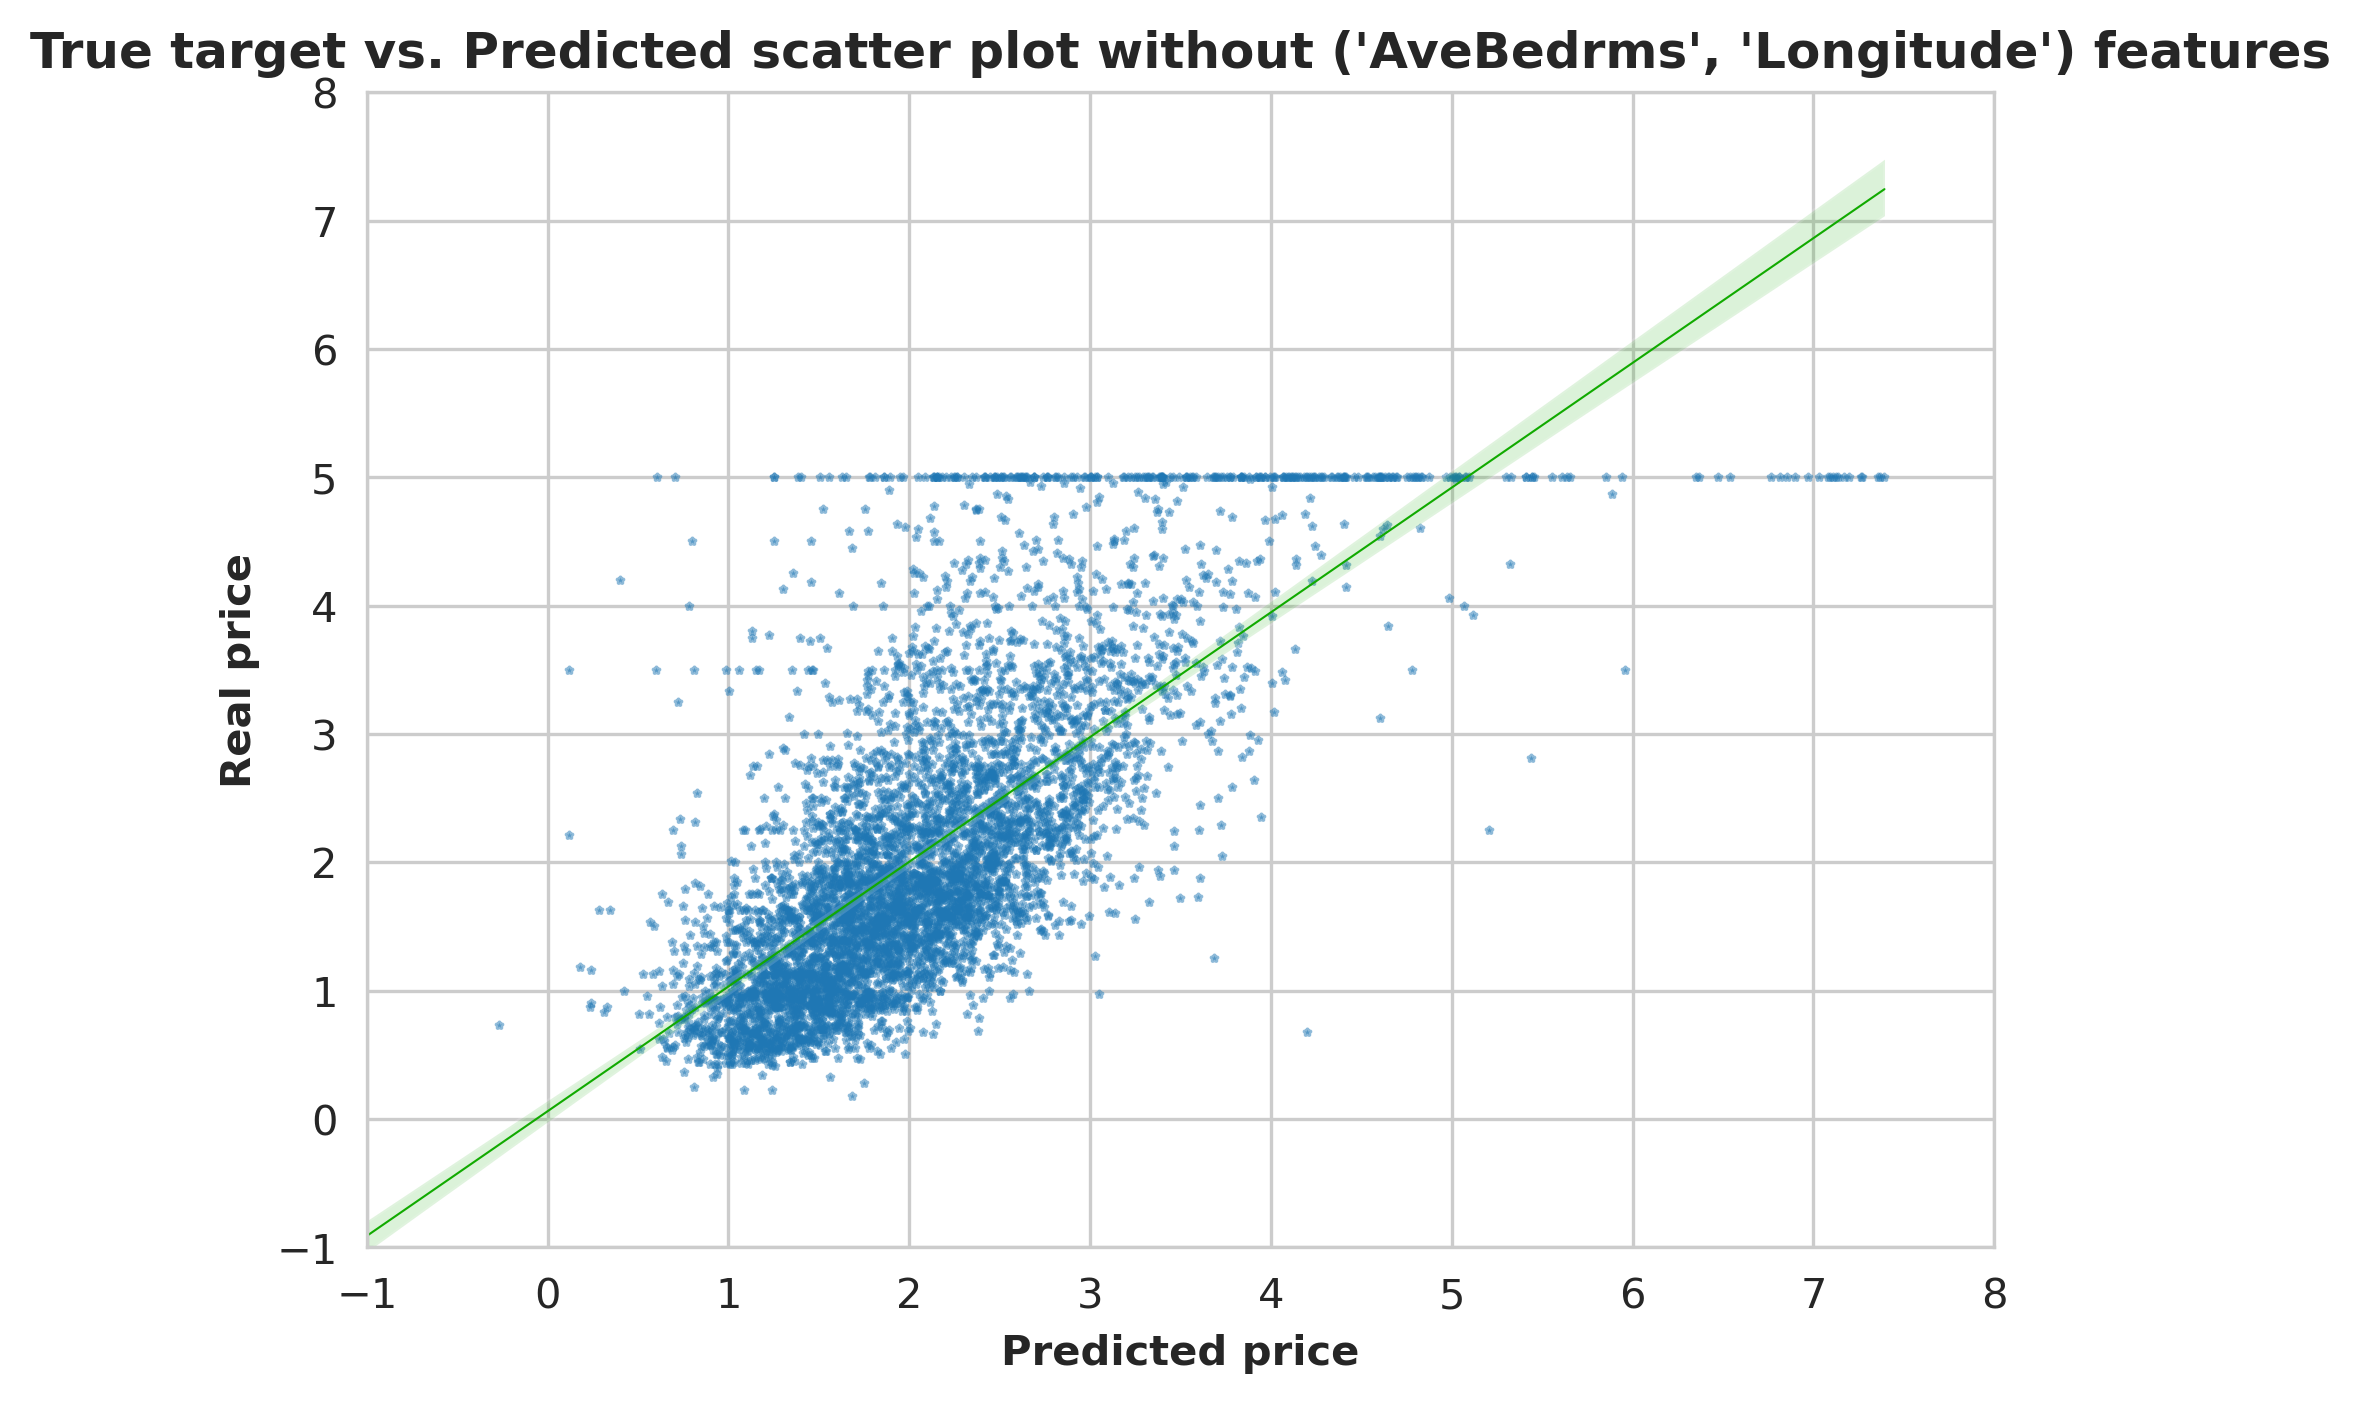

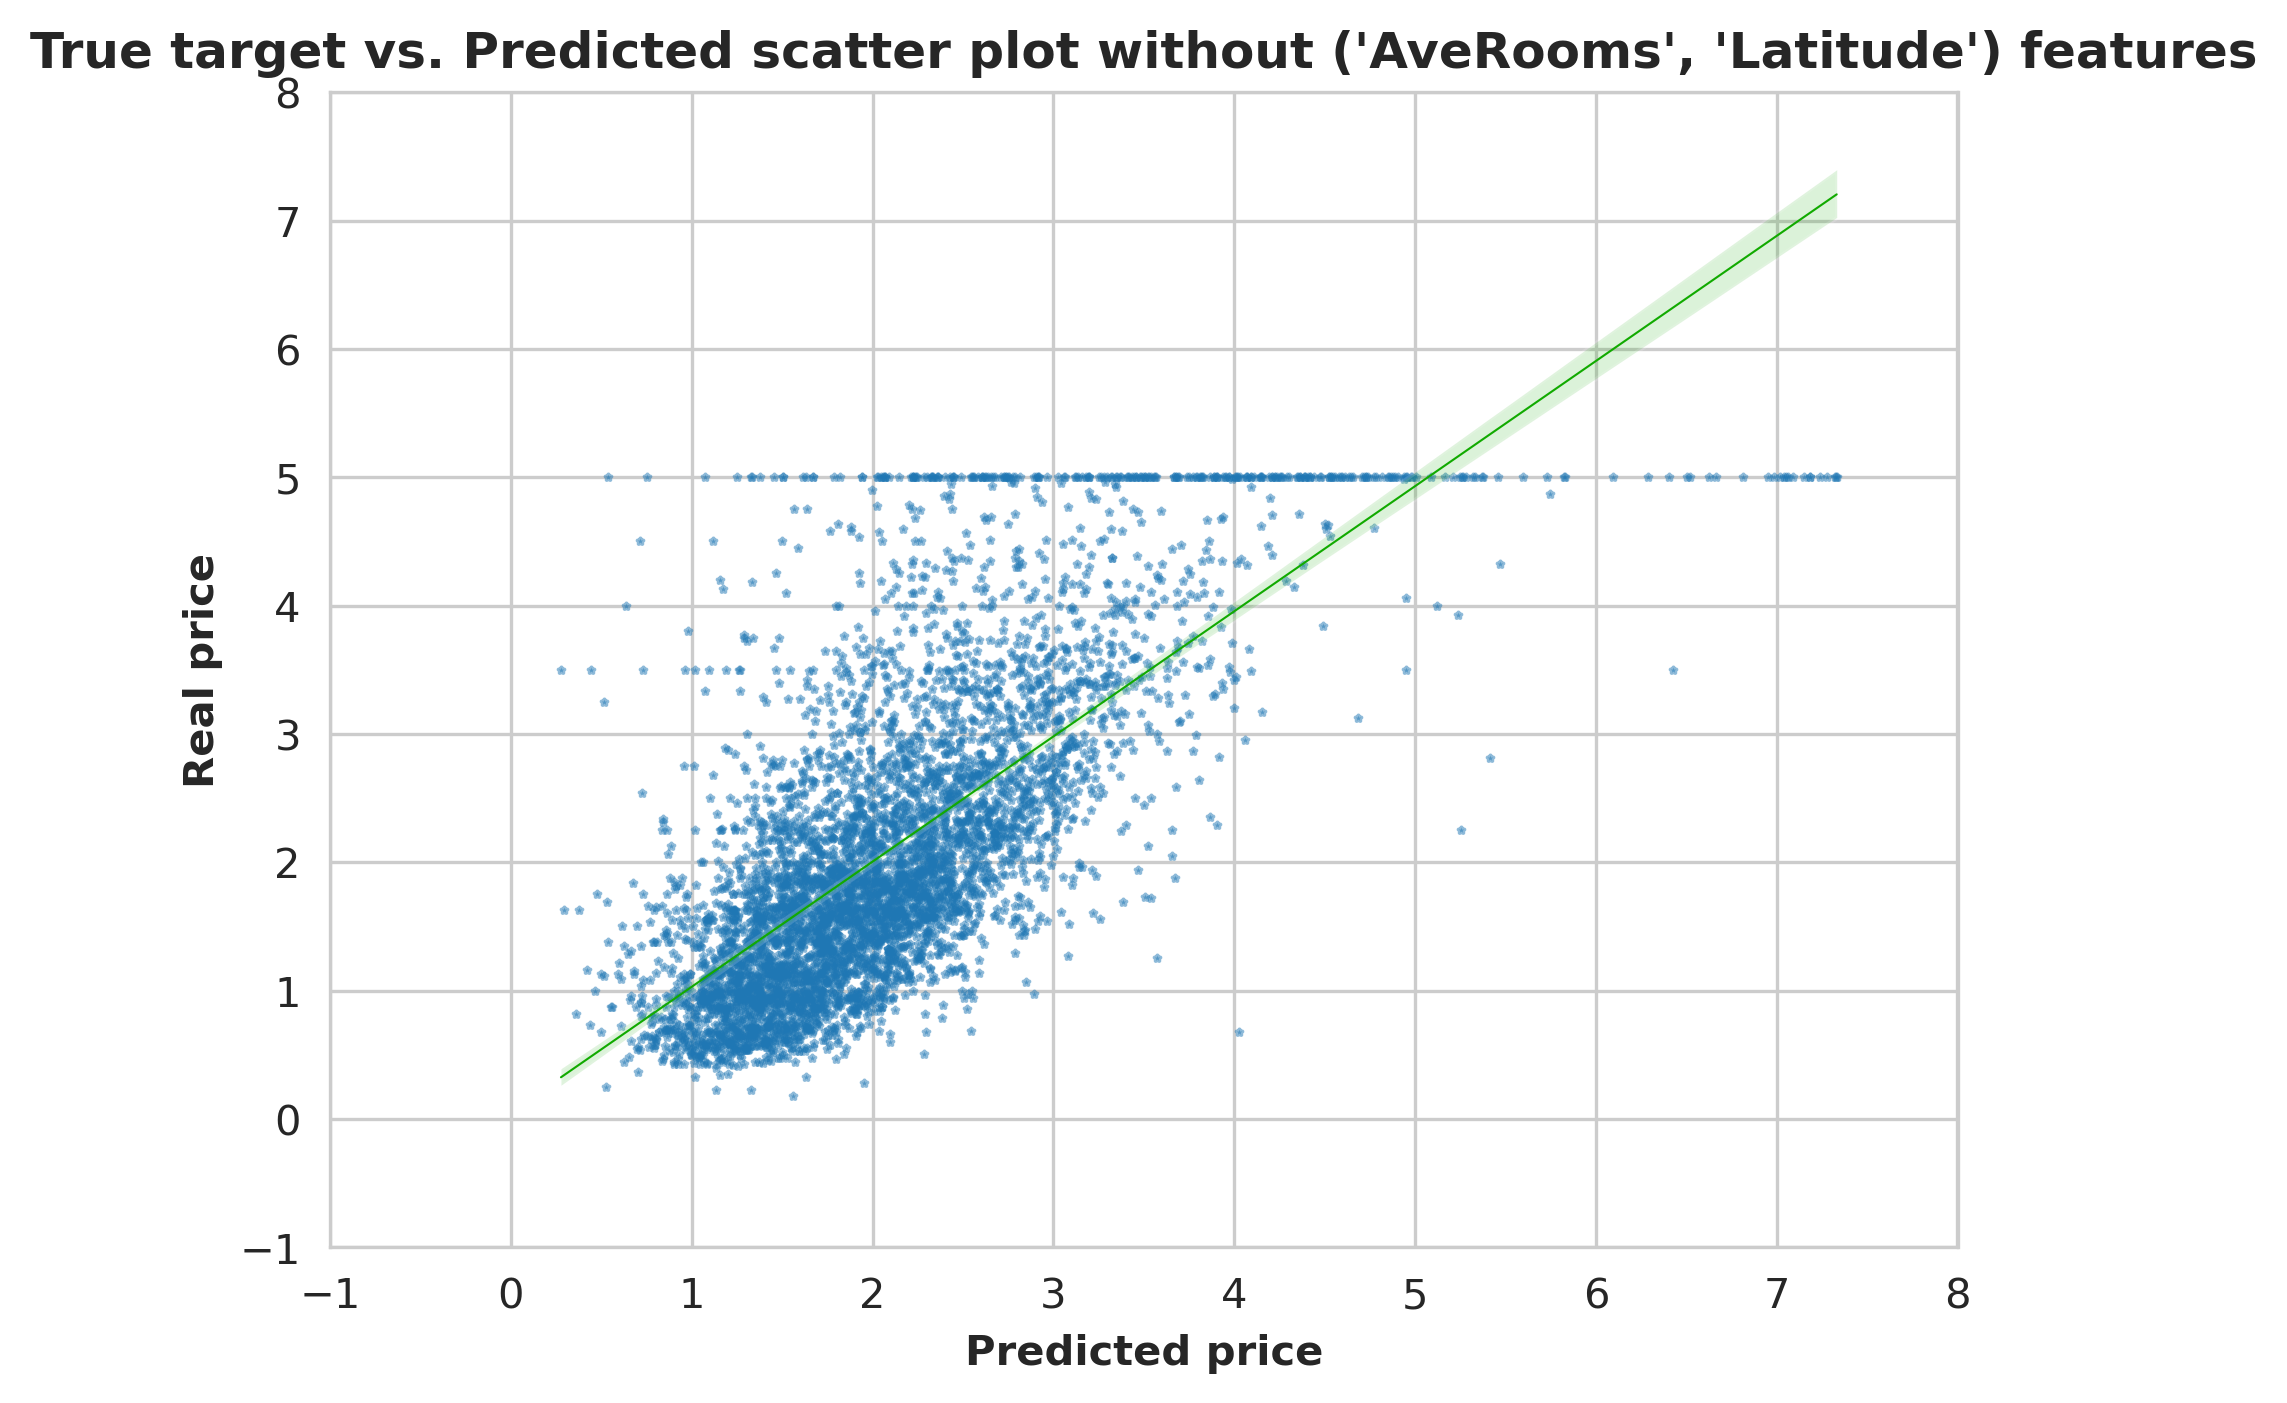

In [38]:
two_drops_to_prop(X, y)

I think that linear model for prediction without *AveBedrms* and *Longitude* is the best one. Let's do a little bit more analysis for this model.

In [39]:
# I put it all together again for my convenience
X_droped = X.drop(["AveBedrms", "Longitude"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_droped, 
                                                    y, test_size=0.25, 
                                                    random_state=SEED)

pipeline_reg = Pipeline(steps=[('scaler', StandardScaler()), 
('linear_reg', LinearRegression())])

pipeline_reg.fit(X_train, y_train)
y_pred = pipeline_reg.predict(X_test)

Let's visualize some information about residuals.

In [40]:
model_residuals = np.array(y_test) - np.array(y_pred)

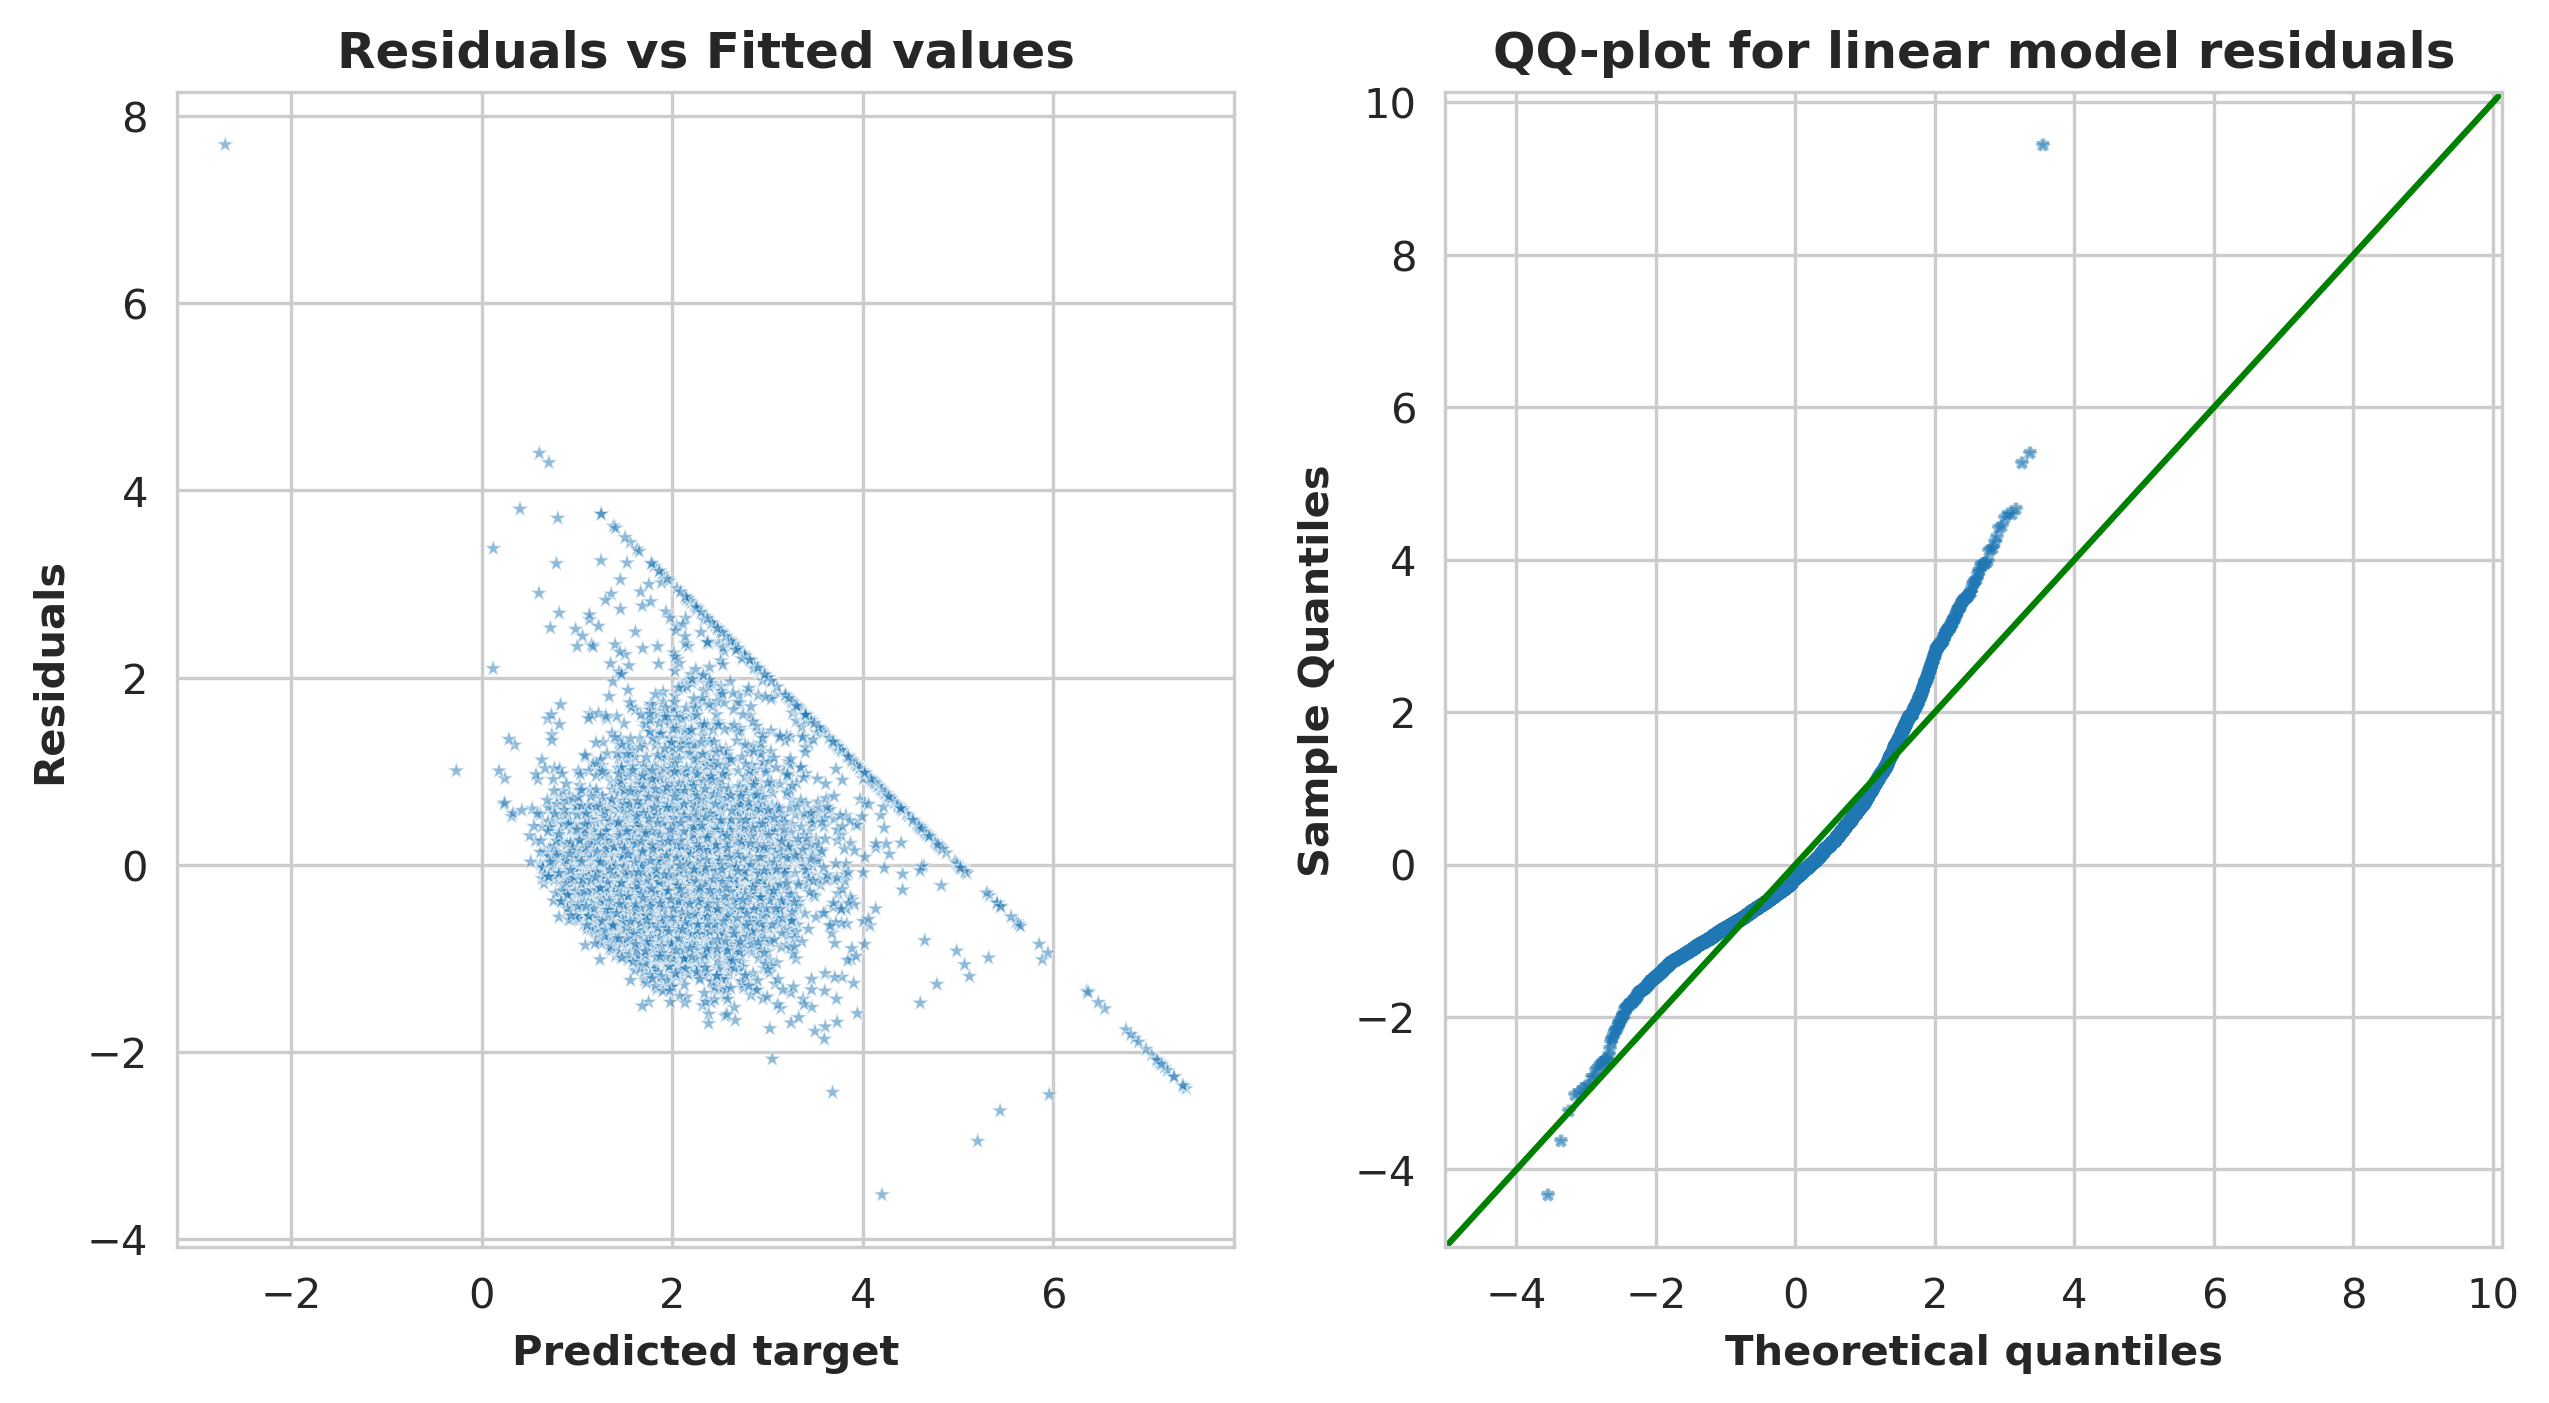

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=300)

sns.scatterplot(x=y_pred, y=model_residuals, alpha=0.5, size=3, 
                marker="*", legend=False, ax=axes[0])
axes[0].set_title('Residuals vs Fitted values', weight='bold')
axes[0].set_xlabel("Predicted target", weight='bold')
axes[0].set_ylabel("Residuals", weight='bold')

sm.qqplot(model_residuals, line='45', marker="*", fit=True, 
          alpha=0.5, ax=axes[1], markersize=3)
axes[1].get_lines()[1].set_color("green")
axes[1].set_title('QQ-plot for linear model residuals', weight='bold')
axes[1].set_xlabel("Theoretical quantiles", weight='bold')
axes[1].set_ylabel("Sample Quantiles", weight='bold');

Overall, the model is not bad. However, as we can see, our model systematically could not predict prices for the most expensive houses. Also the distribution of model residues is far from normal. May be our model may be improved by splitting dataset on two parts: create the separate dataset for the most expensive houses, fit appropriate model, and combine with prediction for cheaper houses. 

### 5. Let's visualize model coefficients to evaluate features

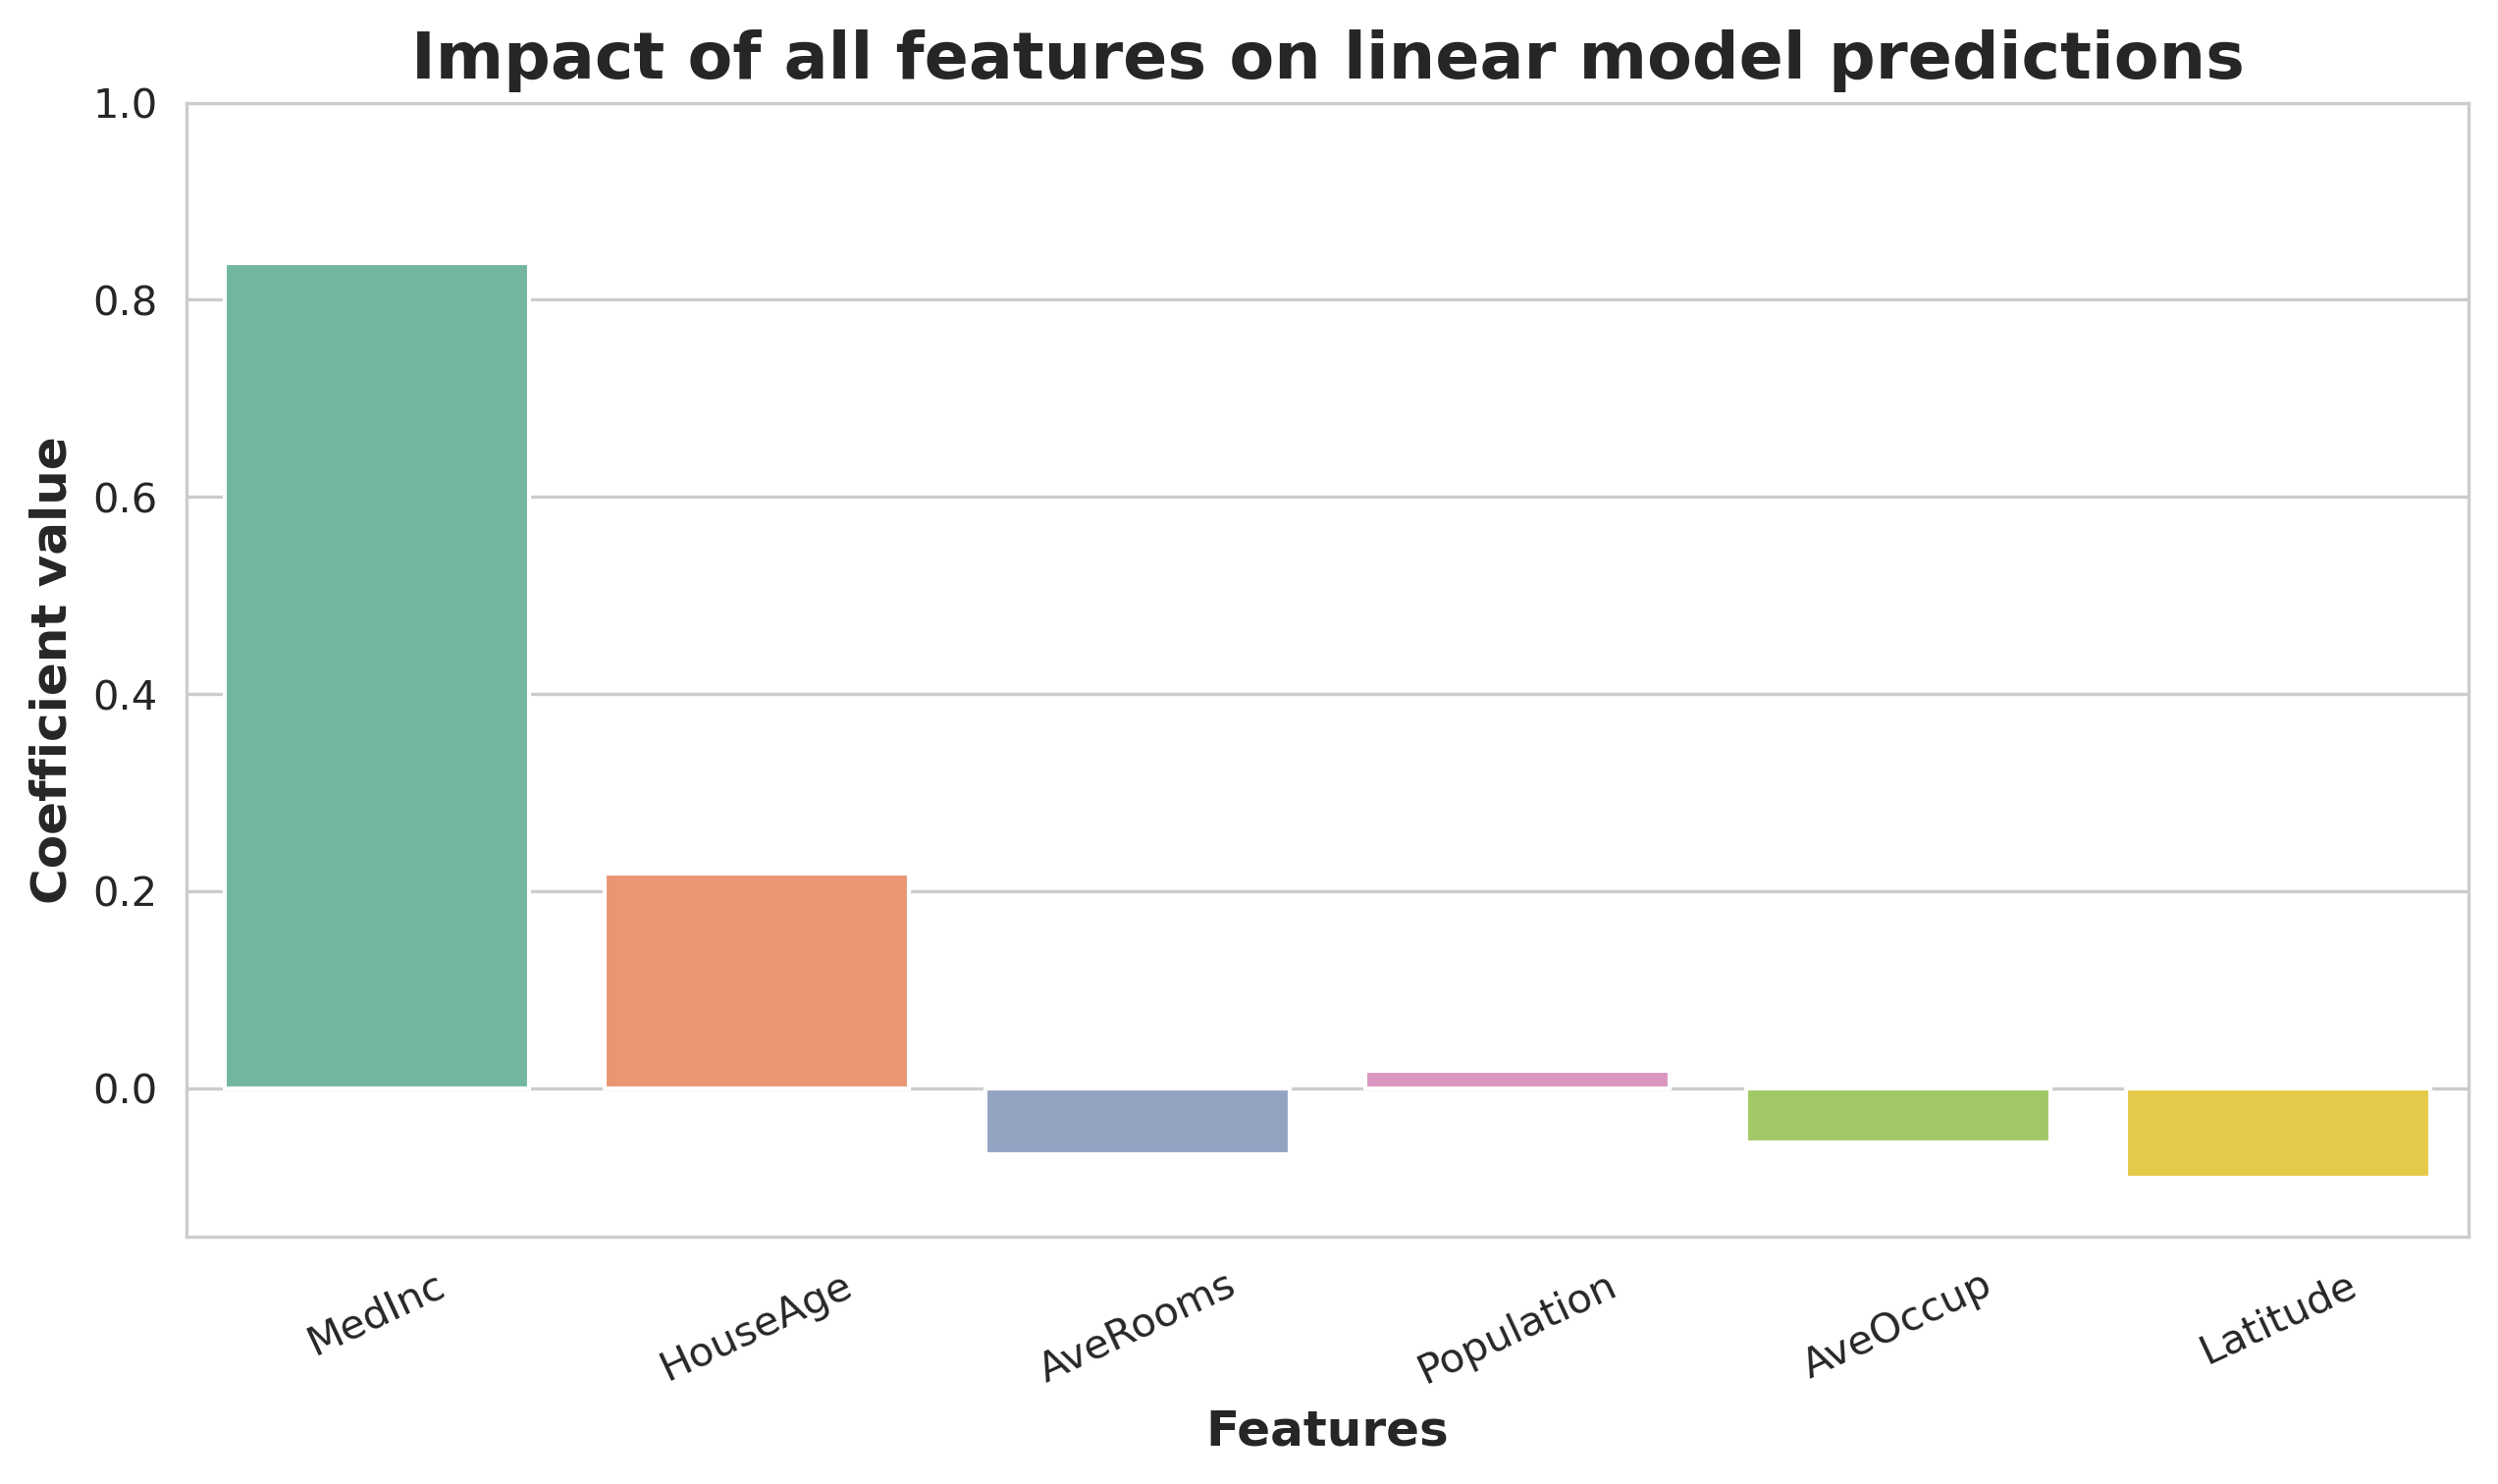

In [42]:
fig = plt.figure(figsize=(10, 5), dpi=300)
sns.barplot(x=X_droped.columns, y=pipeline_reg[1].coef_, palette="Set2")
plt.title('Impact of all features on linear model predictions', size=16, weight='bold')
plt.xlabel('Features', size=12, weight='bold')
plt.xticks(rotation=25)
# ax.set_xticklabels(rotation=45)
plt.ylabel('Coefficient value', size=12, weight='bold')
plt.ylim([-0.15, 1]);

The *MedInc* feature (median incom) is the most important feature for this model: the more money residents earn, the more expensive housing they prefer. For *HouseAge* feature, some houses become more expensive with the ages.

### Задание 3. Реализация логистической регресии (суммарно 10 баллов)

Логистическая регрессия не очень сильно отличается от обычной линейной регрессии и используется в задах классификации. Так как здесь мы снова будем пользоваться градиентным спуском, то нужно определить функцию потерь и ее градиент. Одним из самых популярных вариантов в задаче бинарной классификации является бинарная кросс-энтропия (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Единственная проблема данной функции это возможность получить 0 под знаком логарифма, что не очень хорошо. Попробуем справить с этим "в лоб". Скажем, что наши предсказания могут принимать значения от 0 + eps до 1 - eps, где eps очень маленькое число.

#### Задание 3.1. Реализация сигмоиды (0.5 баллов)

Реализуйте функцию `sigmoid`, которая переводит действительное число $\mathbb R$ в вероятность $[0,1]$.

In [43]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)
    
    return 1 / (1 + np.e ** (- output))

#### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

Так как мы с вами только начинаем изучать машинное обучение, то было бы слишком жестоко просить вас вычислить градиент BCE Loss (он не так сложен, просто нужно привыкнуть). Поэтому сразу напишем формулу для него:

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$

In [44]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # So I want escape log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    bce = - (1 / y_true.shape[0]) * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)) 
    return bce


def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    bce_grad = X.T @ (y_pred - y_true)
    return bce_grad


class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

#### Задание 3.3. Предсказания логистической регрессии (2 балла)

Реализуйте метод `predict` у класса `CustomLogisticRegression`, не забудьте про свободный член!

In [45]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        y_pred = sigmoid(X_test @ self.W)
        return y_pred
    
    
    def __repr__(self):
        return "My custom logistic regression"

#### Снова проверим работу алгоритма на простом примере

In [46]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1)

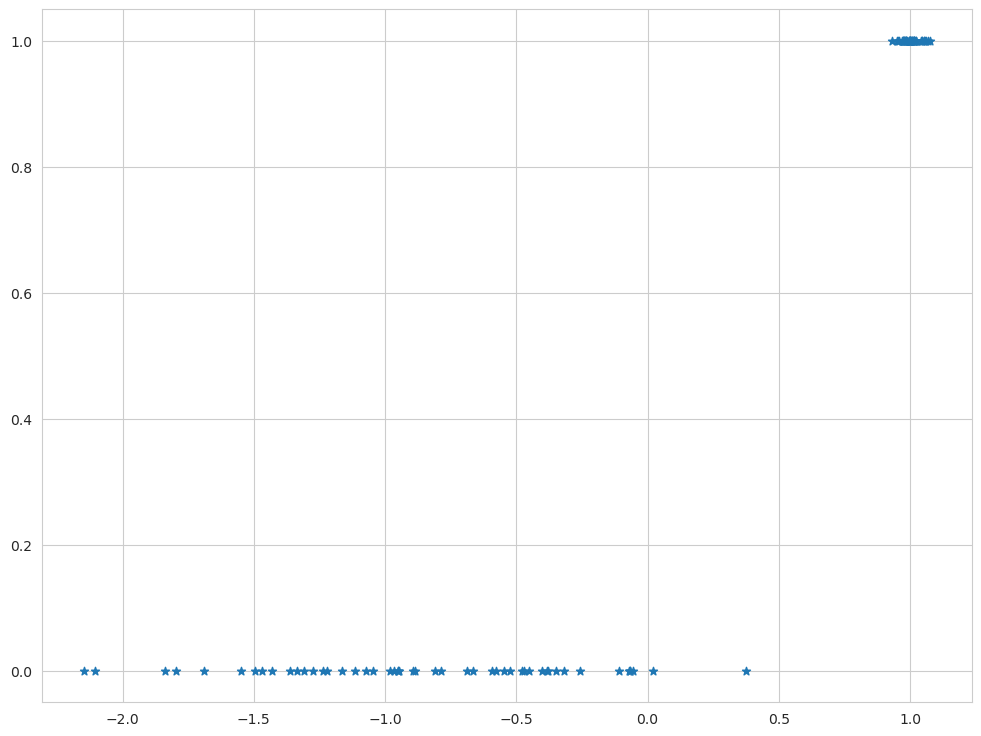

In [47]:
plt.scatter(X, y, marker="*");

In [48]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

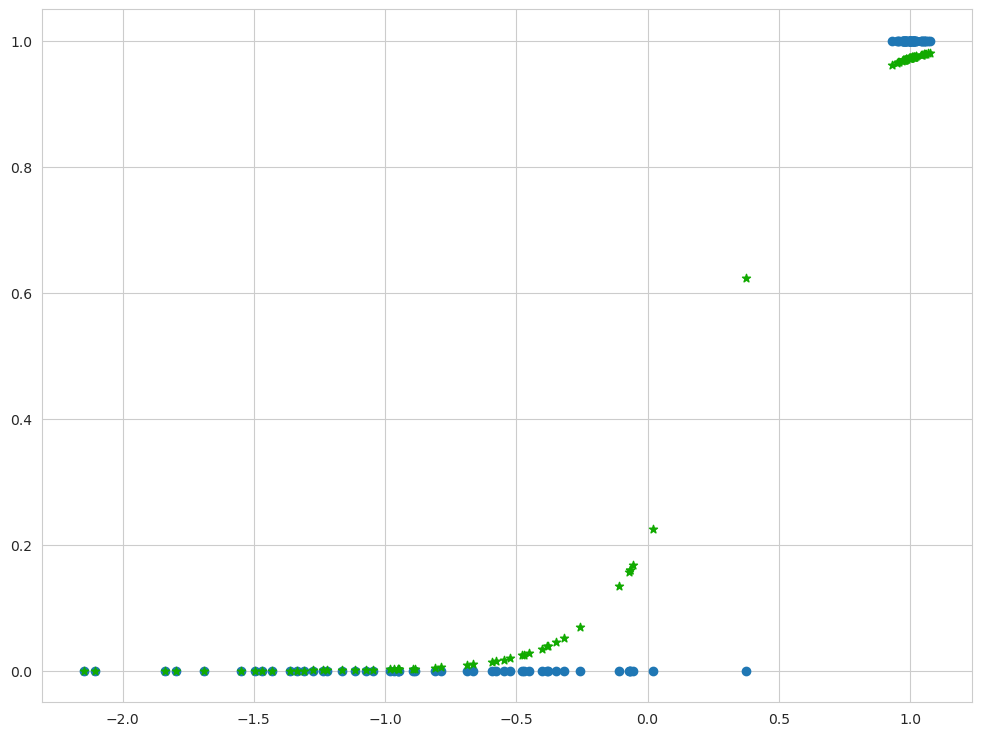

In [49]:
plt.scatter(X, y)
plt.scatter(X, y_pred, marker="*", c="#1a0");

Проверьте качество работы модели при помощи известных вам метрик бинарной классификации.

In [50]:
# 0 for y_pred < 0.5, 1 for y_pred > 0.5
y_pred = np.where(y_pred < 0.5, 0, 1)

In [51]:
# checking prediction metrics using sklearn
sklearn_metrics = [precision_score, recall_score, f1_score, accuracy_score]
for metric in sklearn_metrics:
    value = metric(y, y_pred) 
    print(f'{metric.__name__}: {value}')

precision_score: 0.9803921568627451
recall_score: 1.0
f1_score: 0.99009900990099
accuracy_score: 0.99


Model seems pretty good.

#### Задание 3.4. Применение логистической регрессии (5 баллов)

Мы будем использовать данные по свойствам покемонов (https://www.kaggle.com/abcsds/pokemon). В данном задании вам необходимо сначала сделать краткий EDA (Посмотреть на данные и их распределения, а также посмотреть, как различные признаки связаны между собой и с целевой переменной (`Legendary`)).

Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

In [52]:
pokemon = pd.read_csv("Pokemon.csv")
pokemon.head()

#                   Name Type 1  Type 2  Total  HP  Attack  Defense  \
0  1              Bulbasaur  Grass  Poison    318  45      49       49   
1  2                Ivysaur  Grass  Poison    405  60      62       63   
2  3               Venusaur  Grass  Poison    525  80      82       83   
3  3  VenusaurMega Venusaur  Grass  Poison    625  80     100      123   
4  4             Charmander   Fire     NaN    309  39      52       43   

   Sp. Atk  Sp. Def  Speed  Generation  Legendary  
0       65       65     45           1      False  
1       80       80     60           1      False  
2      100      100     80           1      False  
3      122      120     80           1      False  
4       60       50     65           1      False

In [53]:
# dataset size
pokemon.shape

(800, 13)

Here we have 800 observations, 12 features, and "Legendary" as target.

In [54]:
# description
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   Total       800 non-null    int64 
 5   HP          800 non-null    int64 
 6   Attack      800 non-null    int64 
 7   Defense     800 non-null    int64 
 8   Sp. Atk     800 non-null    int64 
 9   Sp. Def     800 non-null    int64 
 10  Speed       800 non-null    int64 
 11  Generation  800 non-null    int64 
 12  Legendary   800 non-null    bool  
dtypes: bool(1), int64(9), object(3)
memory usage: 75.9+ KB


In [55]:
pokemon["Type 2"].isna().sum()

386

Approximately half of the pokemons belongs to only one Type.

In [56]:
for feature in pokemon.columns:
    print(f'{feature}: {pokemon[feature].unique()[:10]} ...')
    print(pokemon[feature].value_counts())
    print("\n")

#: [ 1  2  3  4  5  6  7  8  9 10] ...
479    6
386    4
710    4
711    4
646    3
      ..
250    1
251    1
252    1
253    1
721    1
Name: #, Length: 721, dtype: int64


Name: ['Bulbasaur' 'Ivysaur' 'Venusaur' 'VenusaurMega Venusaur' 'Charmander'
 'Charmeleon' 'Charizard' 'CharizardMega Charizard X'
 'CharizardMega Charizard Y' 'Squirtle'] ...
Bulbasaur              1
Uxie                   1
GalladeMega Gallade    1
Probopass              1
Dusknoir               1
                      ..
Lugia                  1
Ho-oh                  1
Celebi                 1
Treecko                1
Volcanion              1
Name: Name, Length: 800, dtype: int64


Type 1: ['Grass' 'Fire' 'Water' 'Bug' 'Normal' 'Poison' 'Electric' 'Ground'
 'Fairy' 'Fighting'] ...
Water       112
Normal       98
Grass        70
Bug          69
Psychic      57
Fire         52
Electric     44
Rock         44
Dragon       32
Ground       32
Ghost        32
Dark         31
Poison       28
Steel        27
Fighting 

Hm, target is too much disbalanced.

2) Let's take a look on mean and std for all features

In [57]:
pokemon.describe()

#      Total          HP      Attack     Defense     Sp. Atk  \
count  800.000000  800.00000  800.000000  800.000000  800.000000  800.000000   
mean   362.813750  435.10250   69.258750   79.001250   73.842500   72.820000   
std    208.343798  119.96304   25.534669   32.457366   31.183501   32.722294   
min      1.000000  180.00000    1.000000    5.000000    5.000000   10.000000   
25%    184.750000  330.00000   50.000000   55.000000   50.000000   49.750000   
50%    364.500000  450.00000   65.000000   75.000000   70.000000   65.000000   
75%    539.250000  515.00000   80.000000  100.000000   90.000000   95.000000   
max    721.000000  780.00000  255.000000  190.000000  230.000000  194.000000   

          Sp. Def       Speed  Generation  
count  800.000000  800.000000   800.00000  
mean    71.902500   68.277500     3.32375  
std     27.828916   29.060474     1.66129  
min     20.000000    5.000000     1.00000  
25%     50.000000   45.000000     2.00000  
50%     70.000000   65.000000     3.00000  
75%     90.000000   90.000000     5.00000  
max    230.000000  180.000000     6.00000

Feature "#" is ID of a pokemon, we will drop it. "Name" is unique for almost all pokemons, we will drop it too. "Generation" is categorial and nead to be preprocessed. All numerical features should be standardized. Let's check "Total" feature. Is it sum of all other numerical ones?

In [58]:
pokemon.loc[0,"Total"] == pokemon.iloc[0, 5:11].sum()

True

Yes, *Total* value is the sum of all numeric features for pokemon. We will drop it too.

3) Let's visualize distribution for both features and target

I think it is a good idea to make generic feature with information about number of Types for each pokemon. Therefore we will combat the problem with the number of Nan in "Type 2" feature.

In [59]:
# new categorial feature to mark dual typed pokemons
pokemon['With_2types'] = pokemon['Type 2'].notna().astype(int)

In [60]:
# setting target to 0 or 1
pokemon['Legendary'] = pokemon['Legendary'].astype(int)

# preparing dataset for prediction
pokemon_processed = pokemon.drop(["#", "Name", "Total", "Type 1", "Type 2"], axis=1)
pokemon_processed

HP  Attack  Defense  Sp. Atk  Sp. Def  Speed  Generation  Legendary  \
0    45      49       49       65       65     45           1          0   
1    60      62       63       80       80     60           1          0   
2    80      82       83      100      100     80           1          0   
3    80     100      123      122      120     80           1          0   
4    39      52       43       60       50     65           1          0   
..   ..     ...      ...      ...      ...    ...         ...        ...   
795  50     100      150      100      150     50           6          1   
796  50     160      110      160      110    110           6          1   
797  80     110       60      150      130     70           6          1   
798  80     160       60      170      130     80           6          1   
799  80     110      120      130       90     70           6          1   

     With_2types  
0              1  
1              1  
2              1  
3              1  
4              0  
..           ...  
795            1  
796            1  
797            1  
798            1  
799            1  

[800 rows x 9 columns]

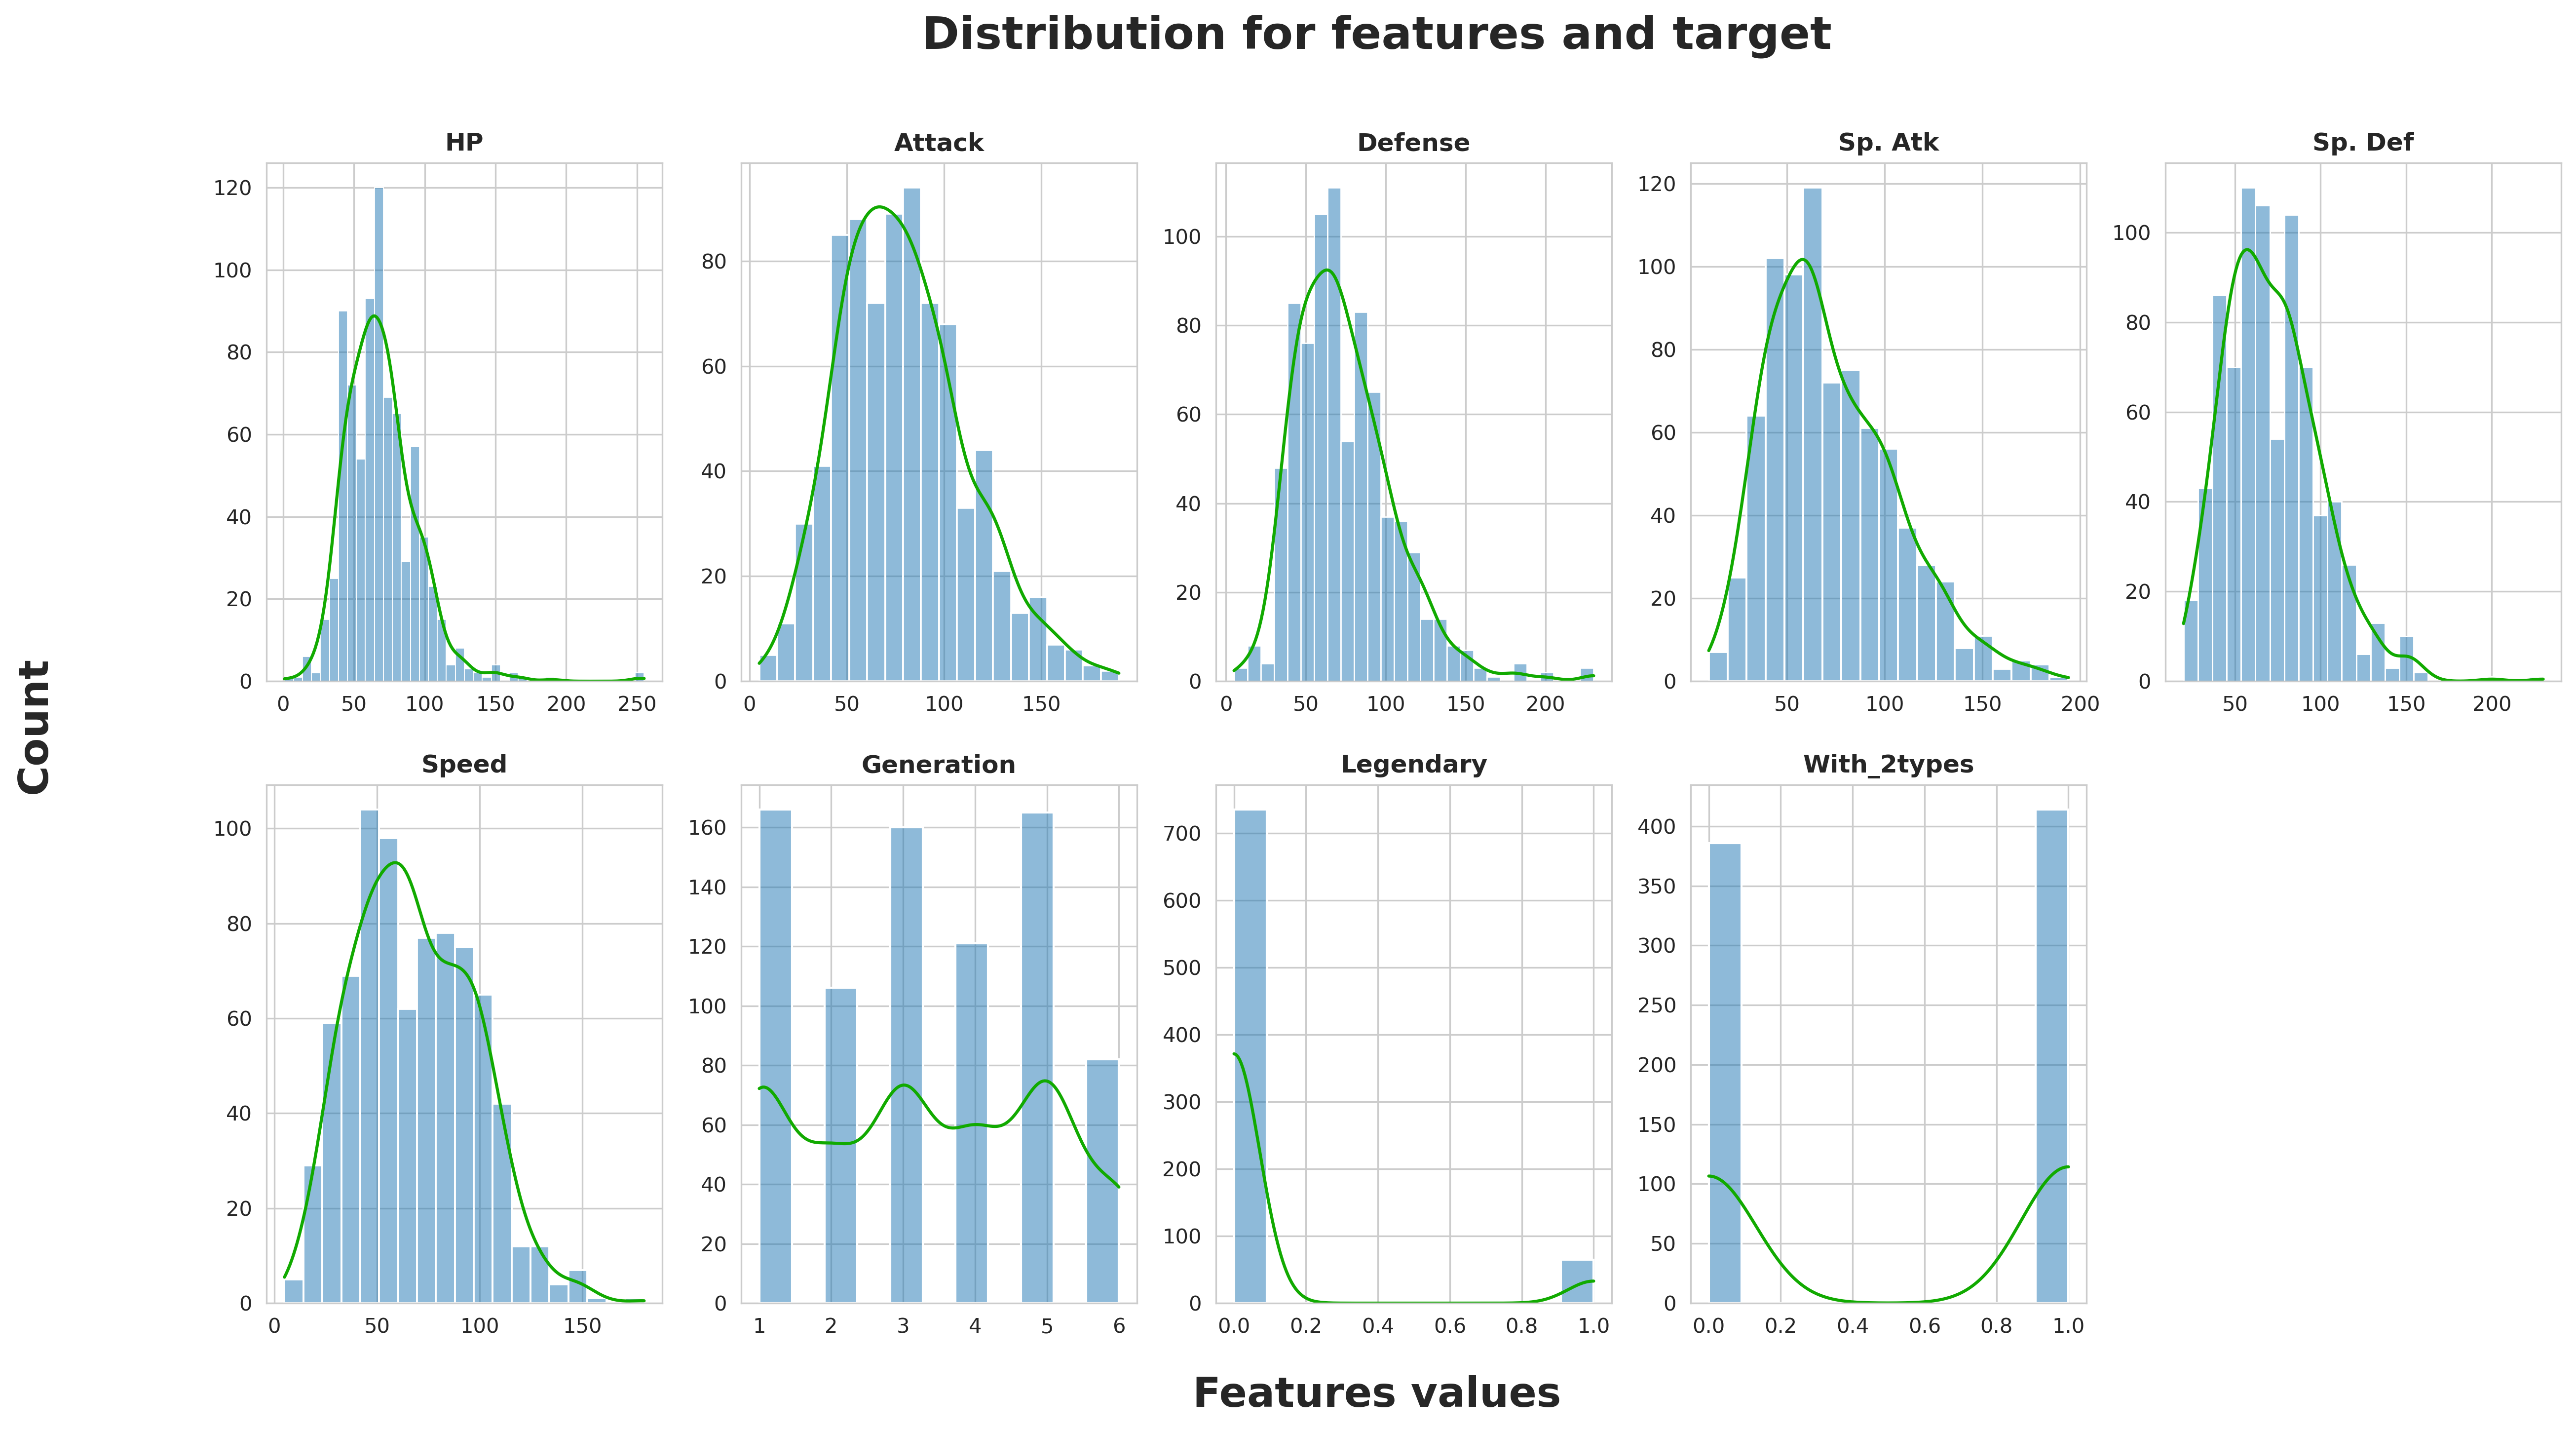

In [61]:
## histplot for all features and target
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20, 10), dpi=300)

for i, ax in zip(range(9), axes.flat):
    sns.histplot(pokemon_processed.iloc[:, i], kde=True, ax=ax)
    ax.set(xlabel='', ylabel='')
    ax.set_title(pokemon_processed.columns[i], fontsize=12, fontweight='bold')
    ax.lines[0].set_color("#1a0")
    
fig.suptitle("Distribution for features and target", fontsize=22, fontweight="bold")
fig.text(0.5, 0.04, 'Features values', ha='center', 
         fontsize=20, fontweight='bold')
fig.text(0.04, 0.5, 'Count', va='center', 
         rotation='vertical', fontsize=20, fontweight='bold')
fig.delaxes(axes[1][4])

plt.show();

4. Let's check whether our features correlates with each other and target

In [62]:
corr = pokemon_processed.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(3))

/tmp/ipykernel_1755/463447767.py:5: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  (corr


Nothing extraordinary. Basic and special combat skills have a positive correlation.

Разделите ваши данные на тестовую и тренировочную выборку.

In [63]:
# splitting dataset on features and target, preparing numeric and categorial features for preprocessing 
num_cols = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
cat_cols = ['Generation', 'With_2types']
features = num_cols + cat_cols
X = pokemon[features]
y = pokemon['Legendary'].values

# splitting dataset on train and test
# sklearn recommends to use stratify for imbalanced target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=SEED, stratify=y)

In [64]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((600, 8), (600,), (200, 8), (200,))

In [65]:
preprocessor = ColumnTransformer(transformers=[('scaler', StandardScaler(), num_cols),
                                               ('ohe', OneHotEncoder(), cat_cols)])
preprocessor.transformers

[('scaler',
  StandardScaler(),
  ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']),
 ('ohe', OneHotEncoder(), ['Generation', 'With_2types'])]

Обучите модель `LogisticRegression` из `sklearn`.

In [66]:
log_reg_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("log_reg", LogisticRegression(n_jobs=4))
])

In [67]:
log_reg_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['HP', 'Attack', 'Defense',
                                                   'Sp. Atk', 'Sp. Def',
                                                   'Speed']),
                                                 ('ohe', OneHotEncoder(),
                                                  ['Generation',
                                                   'With_2types'])])),
                ('log_reg', LogisticRegression(n_jobs=4))])

In [68]:
# prediction metrics for X_train
y_pred_train = log_reg_pipeline.predict(X_train)
sklearn_metrics = [precision_score, recall_score, f1_score, accuracy_score]
for metric in sklearn_metrics:
    value = metric(y_train, y_pred_train) 
    print(f'{metric.__name__}: {value}')

precision_score: 0.7647058823529411
recall_score: 0.5306122448979592
f1_score: 0.6265060240963856
accuracy_score: 0.9483333333333334


In [69]:
# prediction metrics for X_test
y_pred_test = log_reg_pipeline.predict(X_test)
sklearn_metrics = [precision_score, recall_score, f1_score, accuracy_score]
for metric in sklearn_metrics:
    value = metric(y_test, y_pred_test) 
    print(f'{metric.__name__}: {value}')

precision_score: 0.7
recall_score: 0.4375
f1_score: 0.5384615384615384
accuracy_score: 0.94


Выведите метрики вашего классификатора:

1. Нарисуйте [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Изобразите ROC кривую и посчитайте площадь под ней.

3. Скажите, какие признаки оказались наиболее важны для модели.

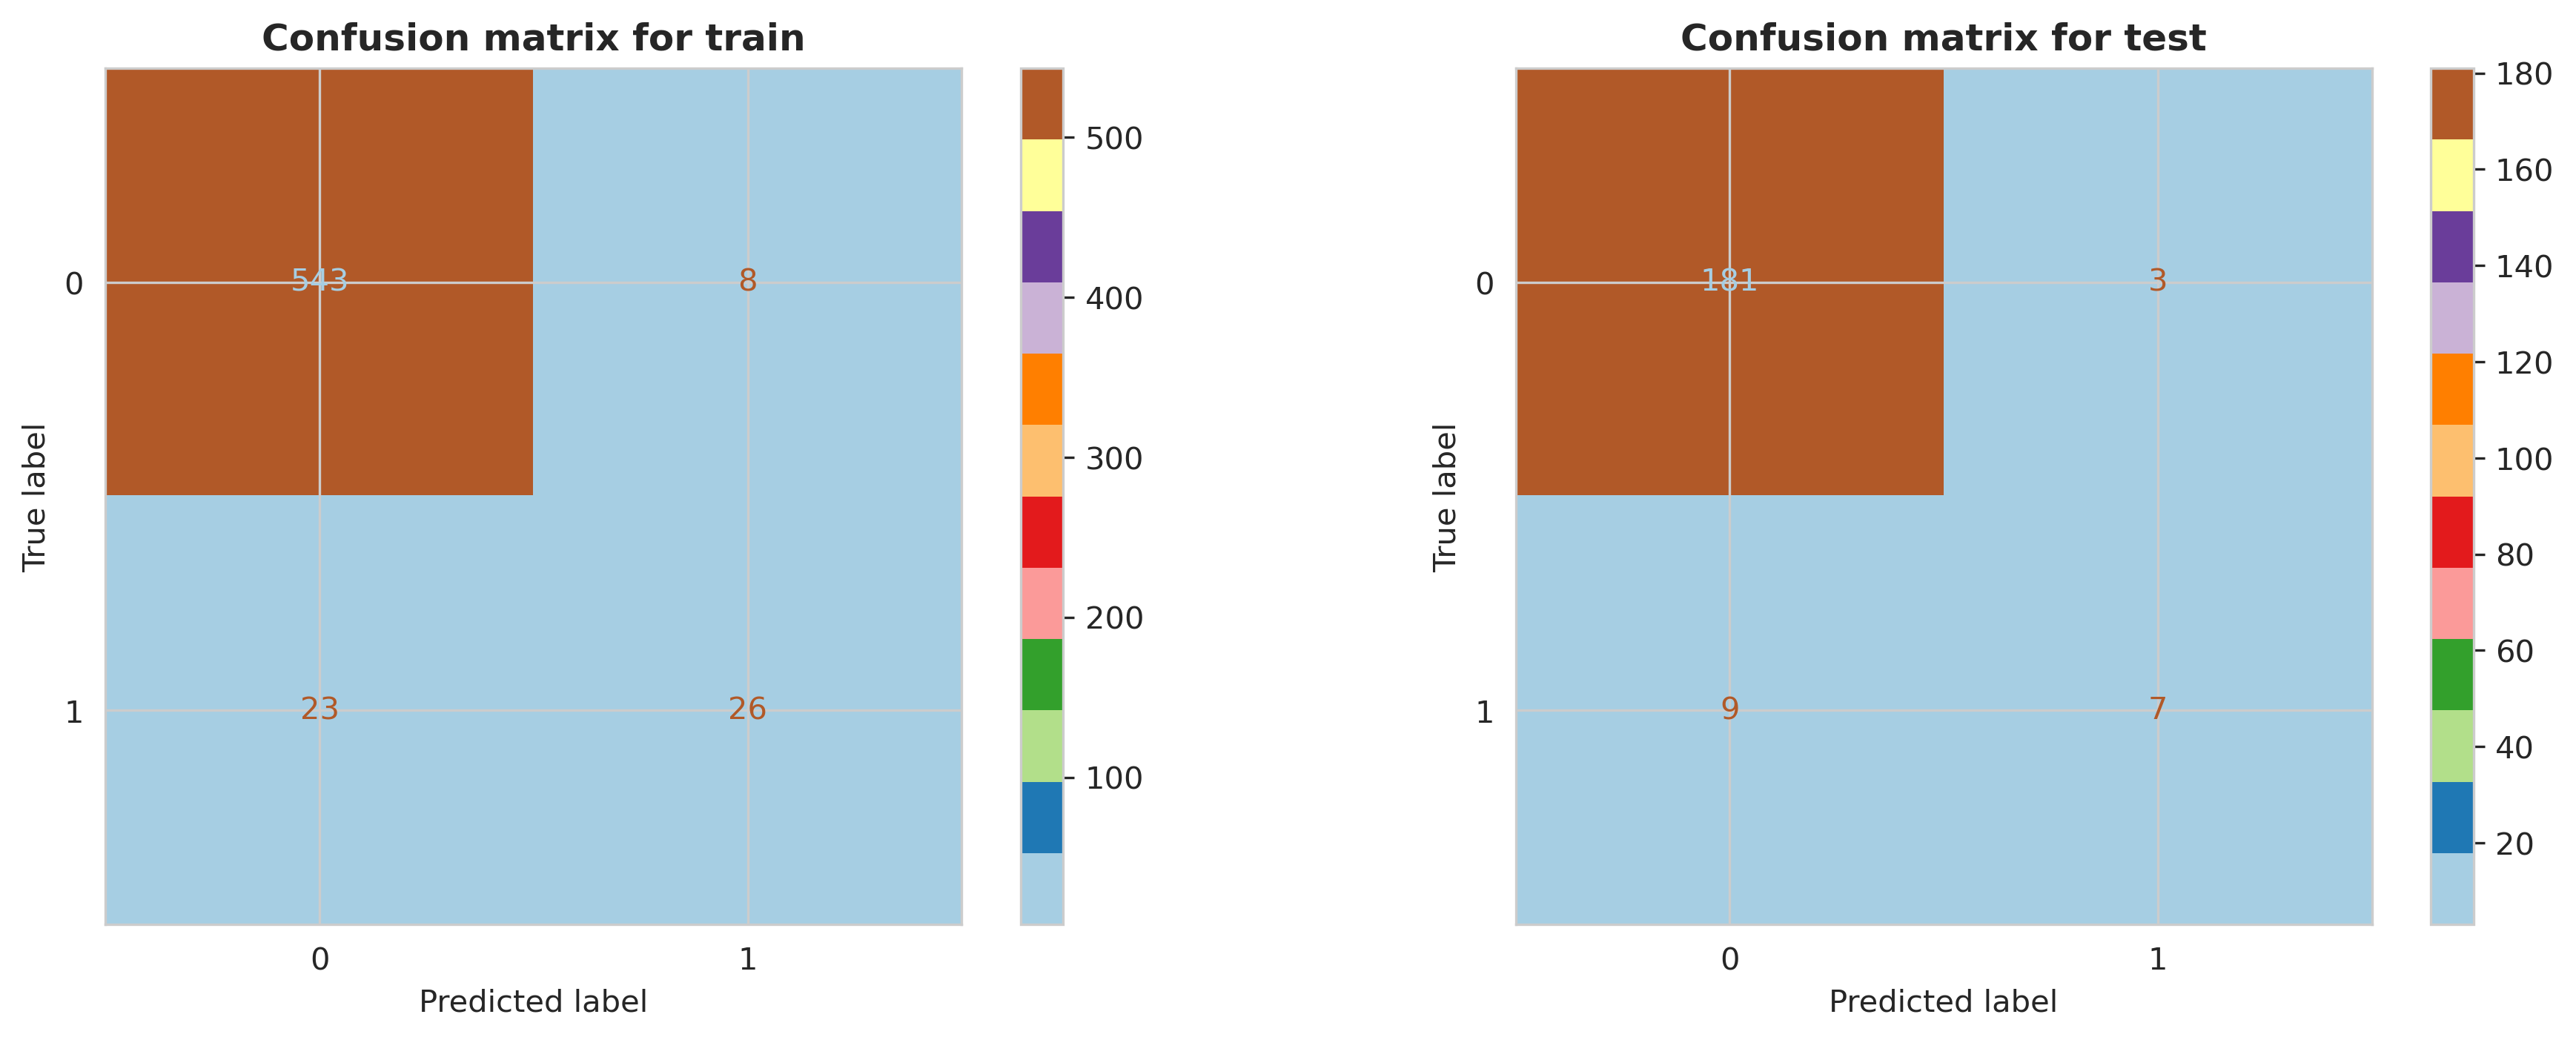

In [70]:
# confusion matrices for train and test
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=300)
ax[0].set_title("Confusion matrix for train", weight='bold')
conf_matrix_train = confusion_matrix(y_train, y_pred_train, labels=log_reg_pipeline[1].classes_)
disp_train = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train, 
                                    display_labels=log_reg_pipeline[1].classes_)
disp_train.plot(ax=ax[0], cmap='Paired')

ax[1].set_title("Confusion matrix for test", weight='bold')
conf_matrix_test = confusion_matrix(y_test, y_pred_test, labels=log_reg_pipeline[1].classes_)
disp_test = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_test,
                                   display_labels=log_reg_pipeline[1].classes_)
disp_test.plot(ax=ax[1], cmap='Paired');

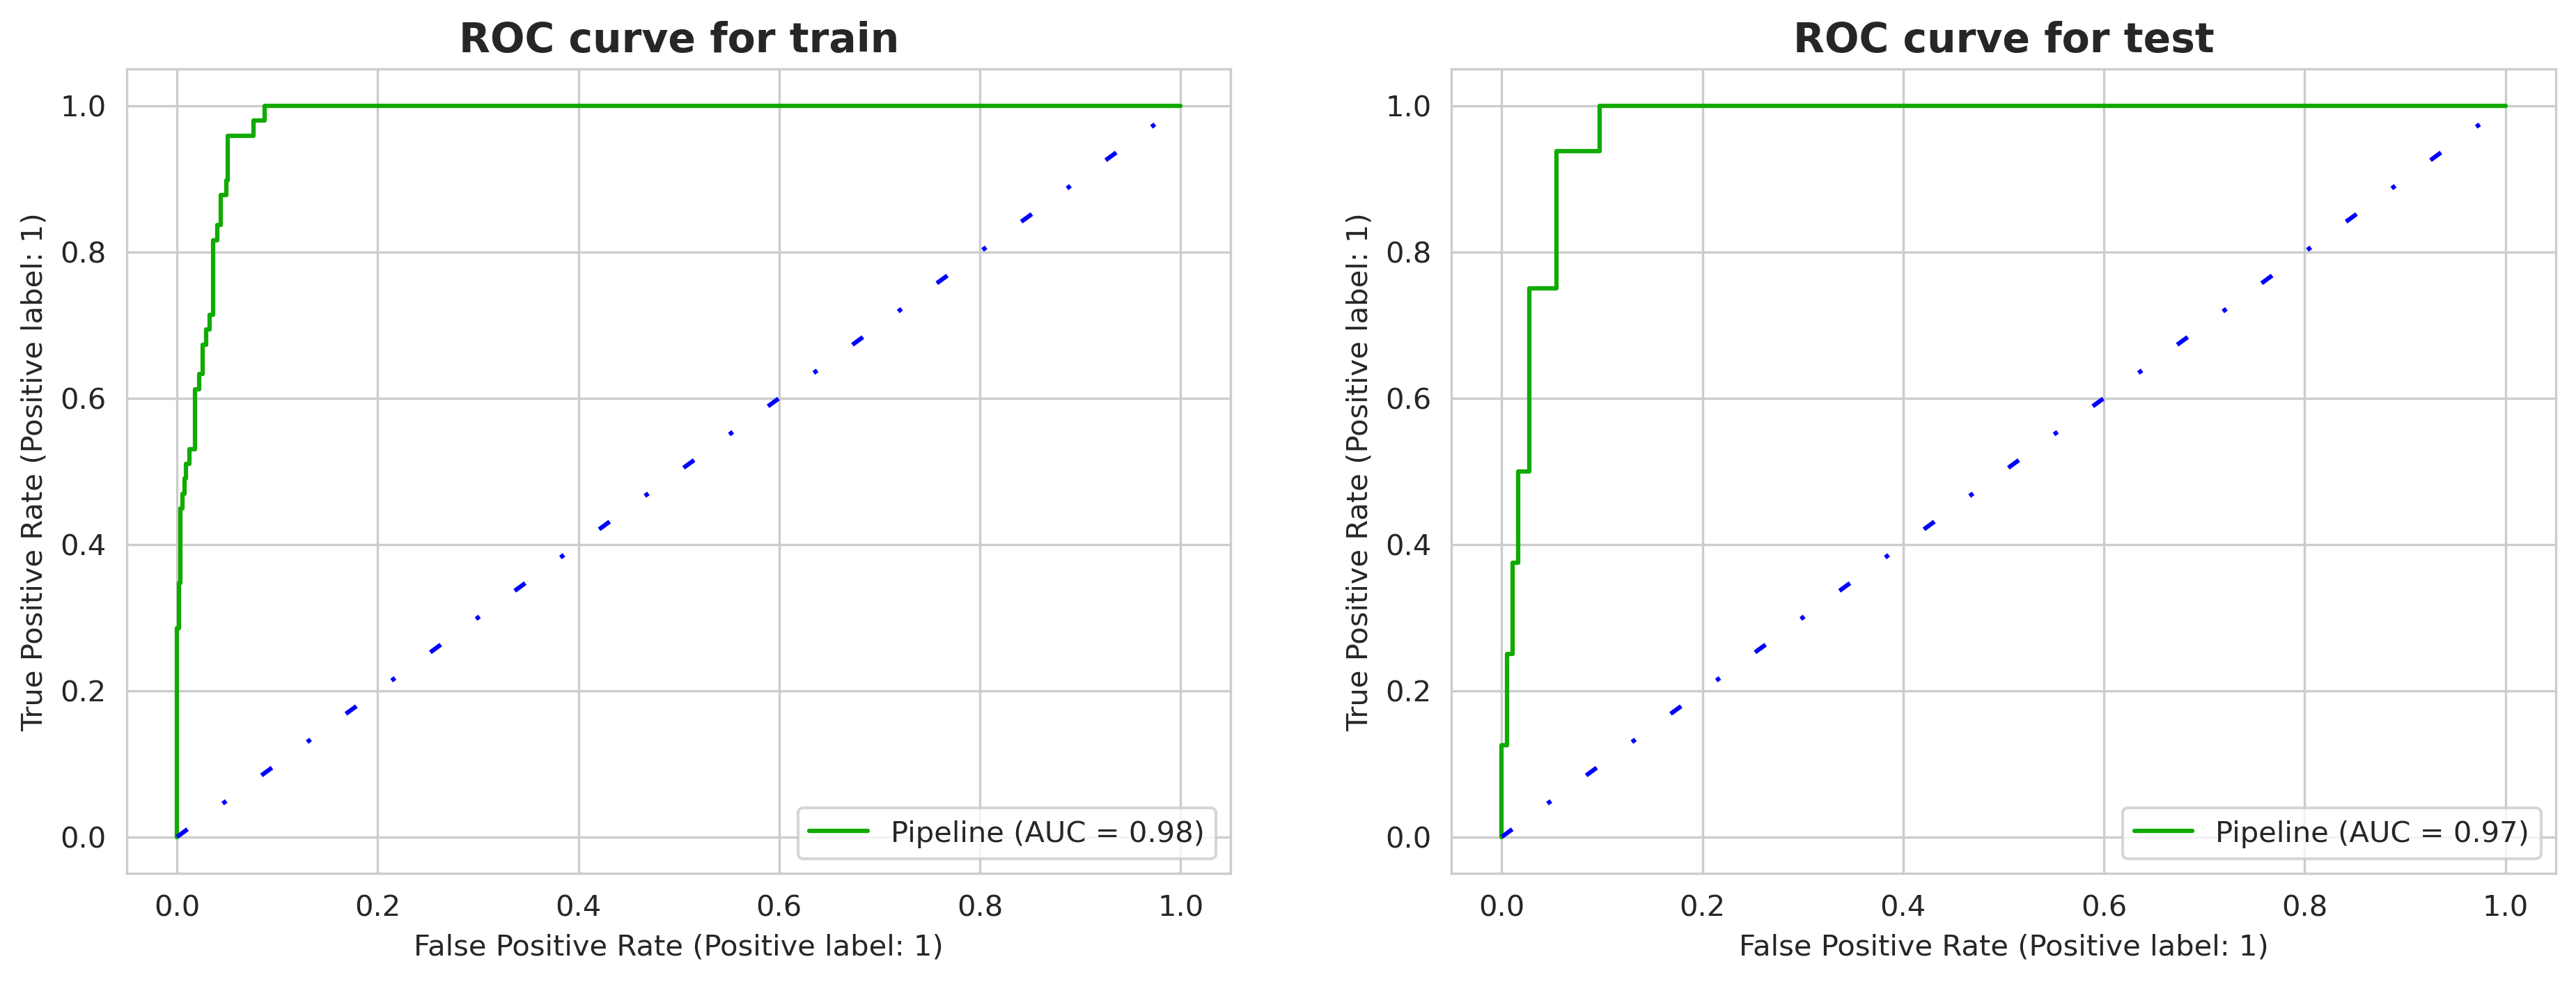

In [71]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), dpi=300)
ax[0].set_title("ROC curve for train", size=14, weight='bold')
RocCurveDisplay.from_estimator(log_reg_pipeline, X_train, y_train, color="#1a0", ax=ax[0])
ax[0].plot([0, 1], color='b', linestyle=(0, (3, 10, 1, 10)))

ax[1].set_title("ROC curve for test", size=14, weight='bold')
RocCurveDisplay.from_estimator(log_reg_pipeline, X_test, y_test, color="#1a0", ax=ax[1])
ax[1].plot([0, 1], color='b', linestyle=(0, (3, 10, 1, 10)));

In [72]:
roc_auc_train = roc_auc_score(y_train, log_reg_pipeline.predict_proba(X_train)[:, 1])
roc_auc_test = roc_auc_score(y_test, log_reg_pipeline.predict_proba(X_test)[:, 1])
print(f'Area under ROC curve for train: {roc_auc_train}')
print(f'Area under ROC curve for text: {roc_auc_test}')

Area under ROC curve for train: 0.9808511426349125
Area under ROC curve for text: 0.9728260869565218


In [73]:
feature_names = log_reg_pipeline[:-1].get_feature_names_out()
feature_names = [i.split('__')[1] for i in feature_names]

features_coeff = pd.DataFrame(log_reg_pipeline[1].coef_[0], index=feature_names, 
                              columns=["coefficients"]).sort_values(by="coefficients", ascending=False)
features_coeff

coefficients
Speed              1.280827
Sp. Def            1.182579
Sp. Atk            1.165667
Defense            1.045235
HP                 1.003366
Attack             0.662245
Generation_6       0.520414
Generation_5       0.494543
With_2types_0      0.386770
Generation_4       0.099123
Generation_3       0.043873
Generation_2      -0.320648
With_2types_1     -0.386615
Generation_1      -0.837150

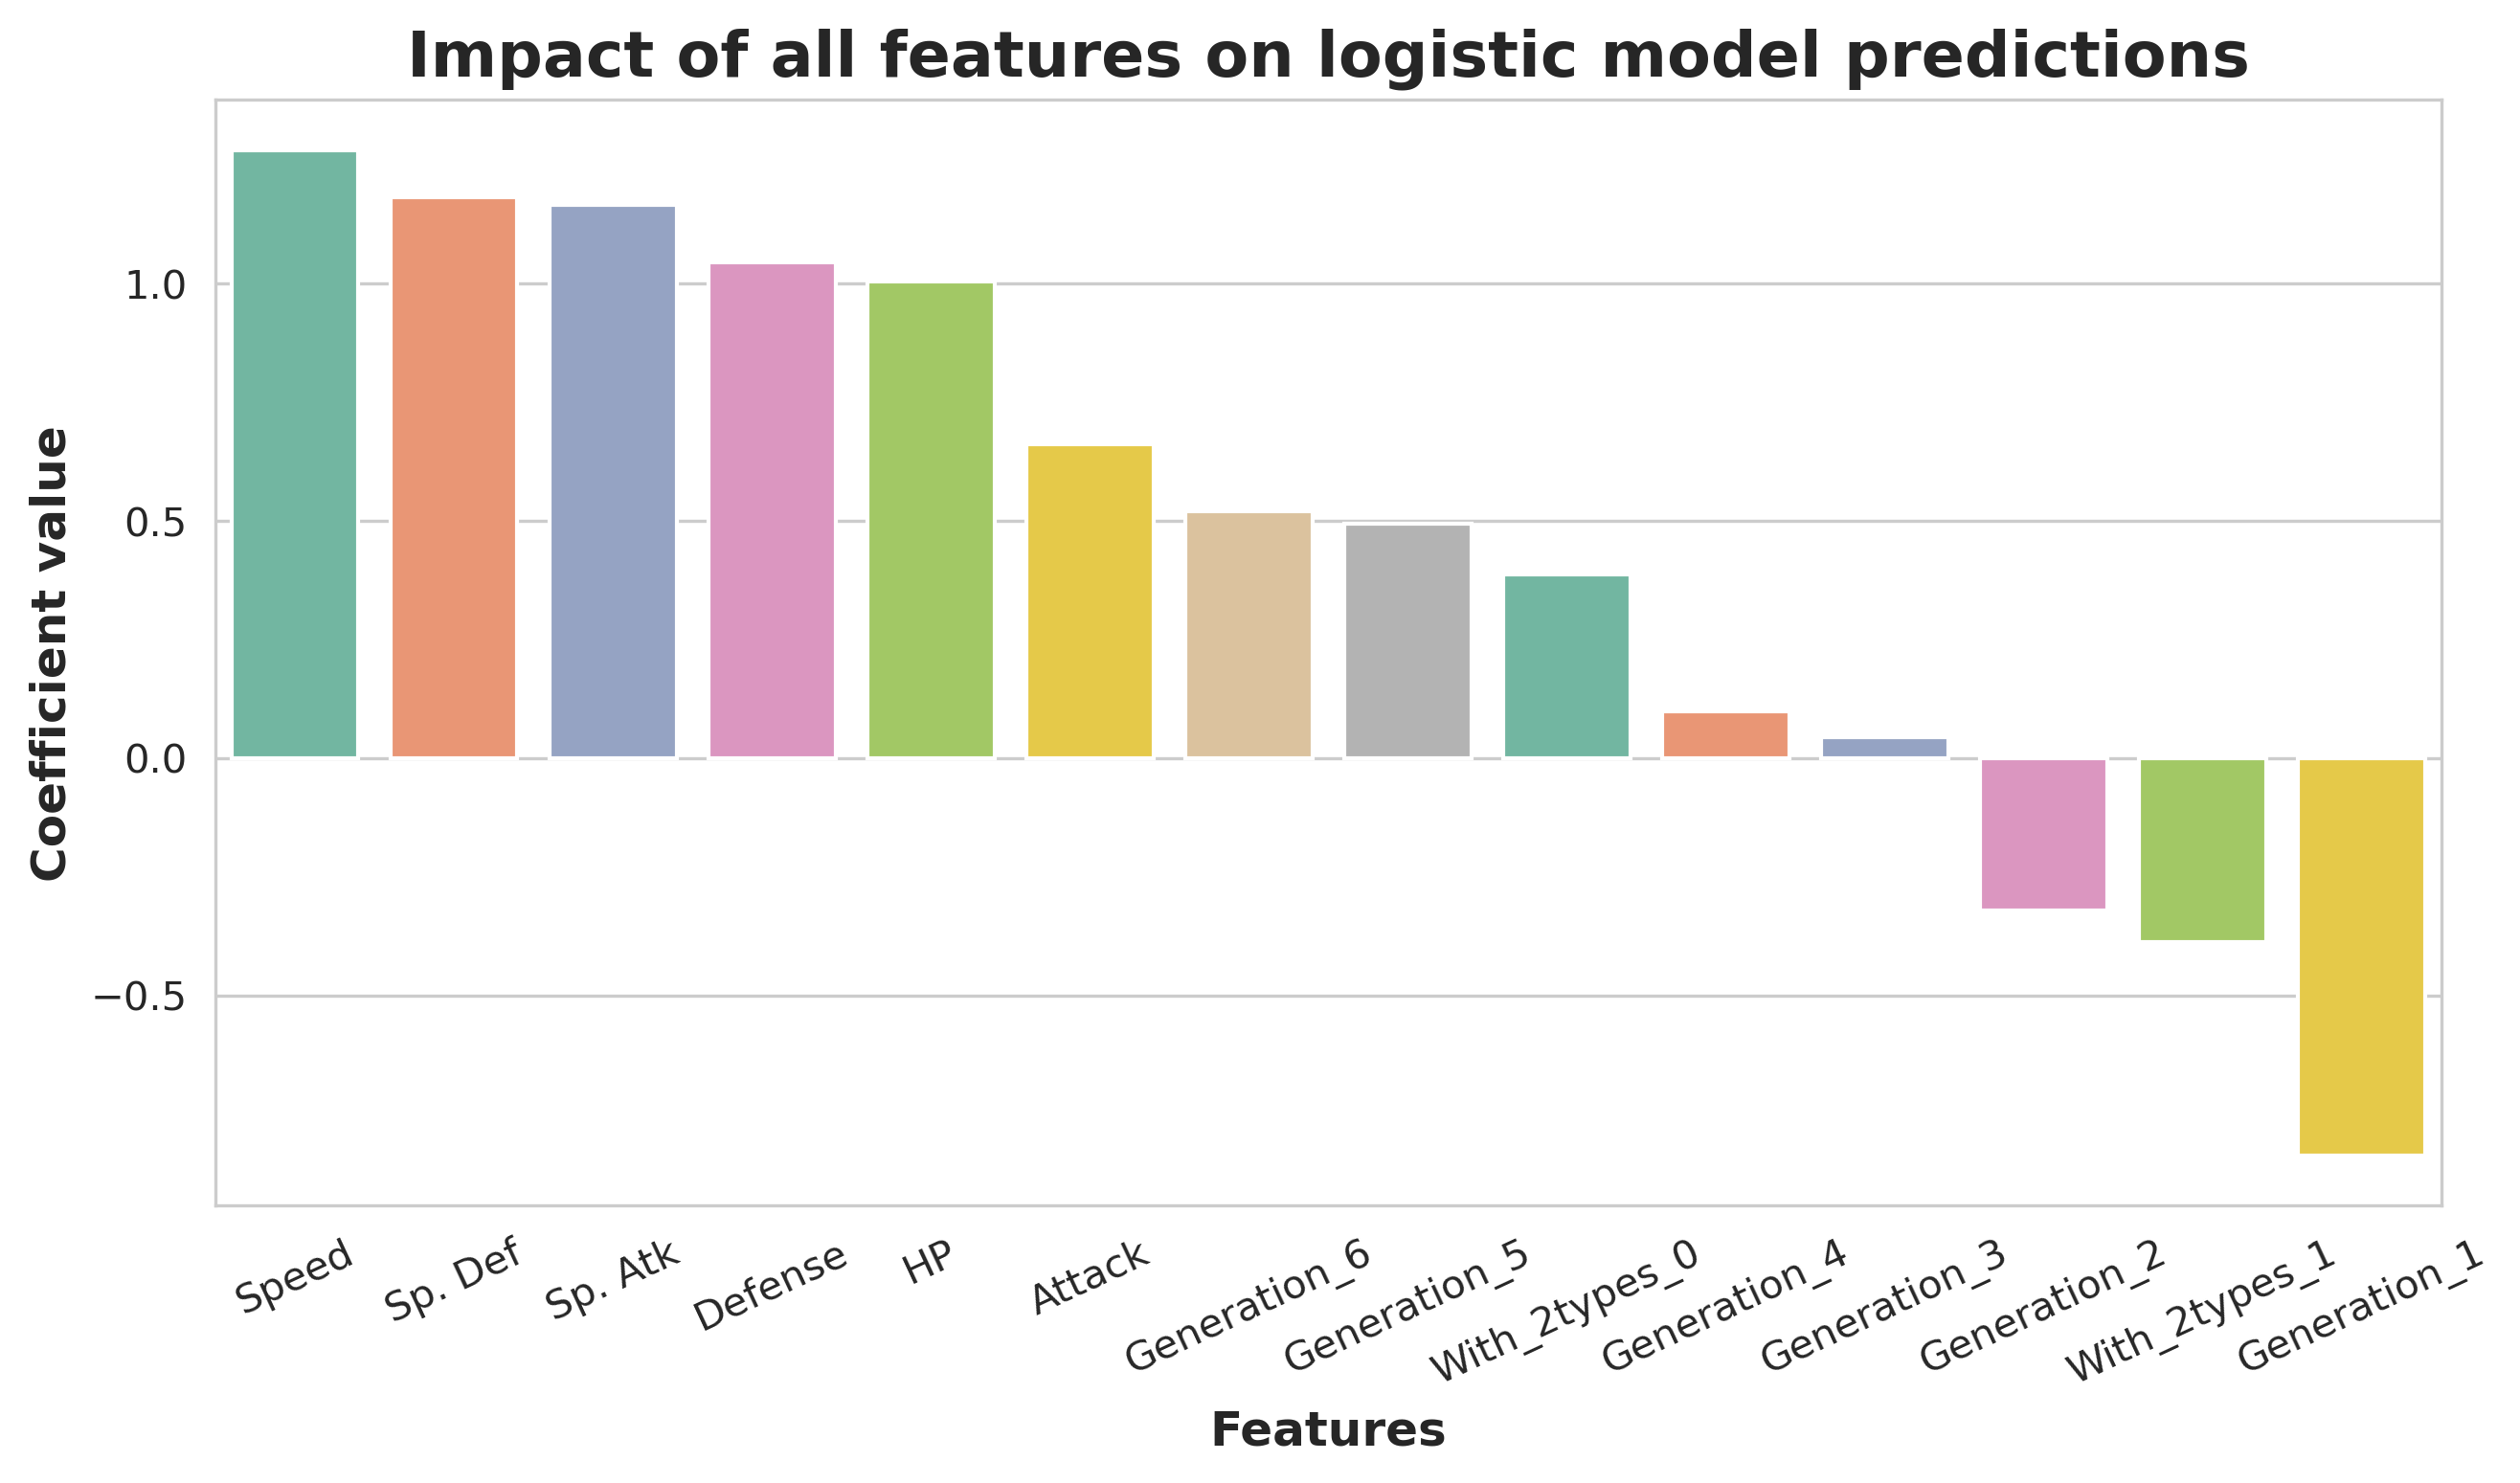

In [74]:
fig = plt.figure(figsize=(10, 5), dpi=300)
sns.barplot(x=features_coeff.index, y=features_coeff.coefficients, palette="Set2")
plt.title('Impact of all features on logistic model predictions', size=16, weight='bold')
plt.xlabel('Features', size=12, weight='bold')
plt.xticks(rotation=25)
plt.ylabel('Coefficient value', size=12, weight='bold');
# plt.ylim([-0.15, 1]);

As we can see, *Speed*, *Special Defence and Atack*, *Basic Defence*, and *HP* features the mostly impact our logistic regression model. Interestingly, with each *Generation* probability to be *Legendary* pokemon is increasing (each new anime season needs more cool and epic pokemons to keep fans' attention, probably). Noteworthy, being dual typed pokemon is not beneficial for its legendarity.

### Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

Расскажите, как вы познакомились с этой группой и скиньте несколько наиболее любимых треков)

У меня нет любимой музыки, на самом деле. В основном, слушаю музыку в машине, пока еду на свою потогонку. В последнее время заходит хип и хап, а так всё подряд:)

А, на случай, если ты водишь ТС, очень бодрит DJ ПЕРЕКРЫТ. Держи пару треков:)

[Чё то принимали](https://music.yandex.ru/album/22277210/track/103889955)

[Бум бум бам бам](https://music.yandex.ru/album/9013131/track/59014791)

## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**